In [4]:
import sys
sys.path.append('/home/fonta42/Desktop/masters-degree/data/vess-map/')
from vess_map_dataset import VessMapDataset

import torch
from torchvision import models
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import random

In [3]:
# Define paths
image_dir = '/home/fonta42/Desktop/masters-degree/data/vess-map/images'
mask_dir = '/home/fonta42/Desktop/masters-degree/data/vess-map/labels'
skeleton_dir = '/home/fonta42/Desktop/masters-degree/data/vess-map/skeletons'

image_size = 256

# Instantiate the dataset
dataset = VessMapDataset(image_dir, mask_dir, skeleton_dir, image_size)

# Access the images
images = dataset.images  # List of PIL Images
labels = dataset.labels  # List of PIL Images (Masks)
skeletons = dataset.skeletons  # List of PIL Images (Skeletons)

In [5]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()

# Dictionary to store activations
activations = {}

# Function to get the activation of a layer
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks to all layers
for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))

/home/fonta42/anaconda3/envs/mestrado/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fonta42/anaconda3/envs/mestrado/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/fonta42/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [6]:
# Preprocessing transformation
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

# Select an image from the dataset
# Let's process the first image as an example
img = images[0]  # PIL Image

# Preprocess the image
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move input to the appropriate device (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_batch = input_batch.to(device)
model.to(device)

# Pass the image through the model to collect activations
with torch.no_grad():
    output = model(input_batch)
    
# activations is a dictionary with layer names and their activations
# Example:
for layer_name in activations.keys():
    print(layer_name)

conv1
bn1
relu
maxpool
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.0
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer1.1
layer1
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample.0
layer2.0.downsample.1
layer2.0.downsample
layer2.0
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer2.1
layer2
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample.0
layer3.0.downsample.1
layer3.0.downsample
layer3.0
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer3.1
layer3
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample.0
layer4.0.downsample.1
layer4.0.downsample
layer4.0
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
layer4.1
layer4
avgpool
fc



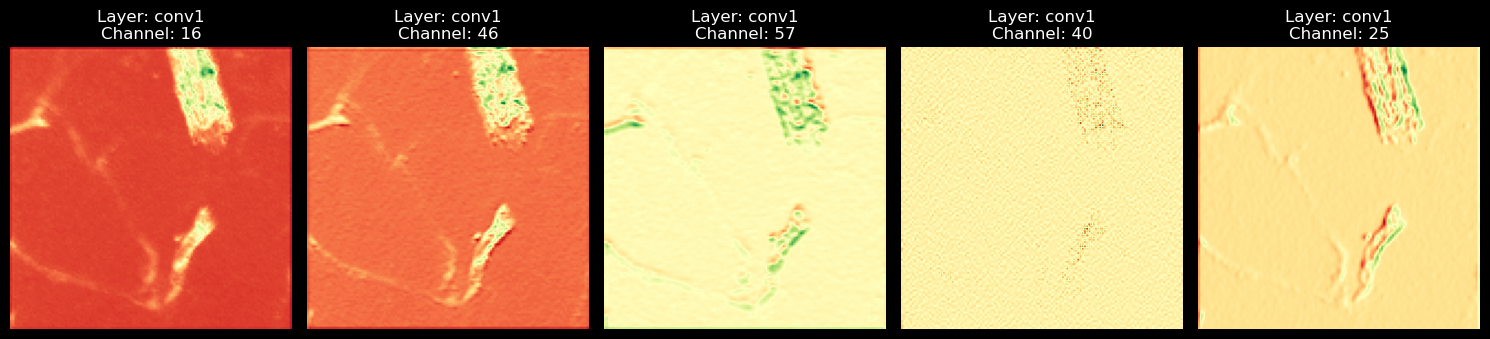

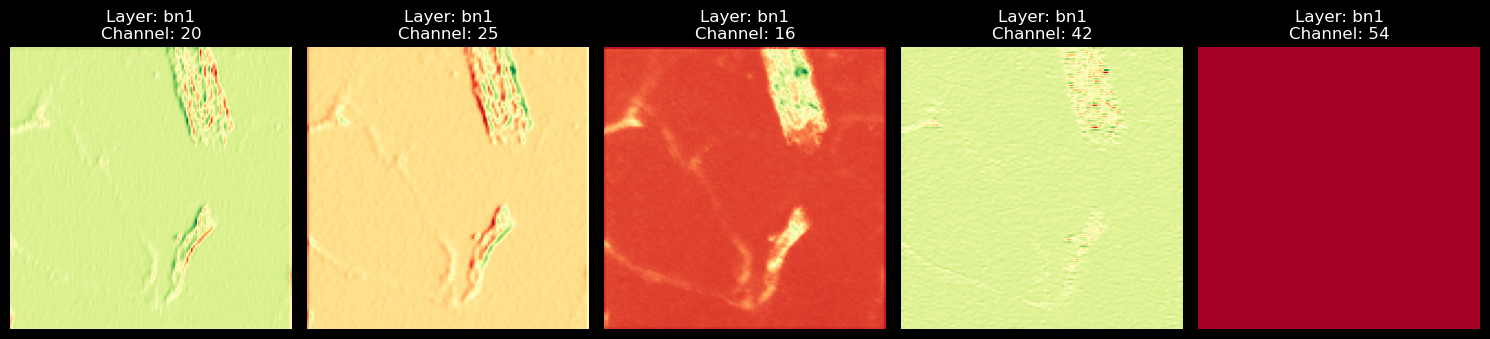

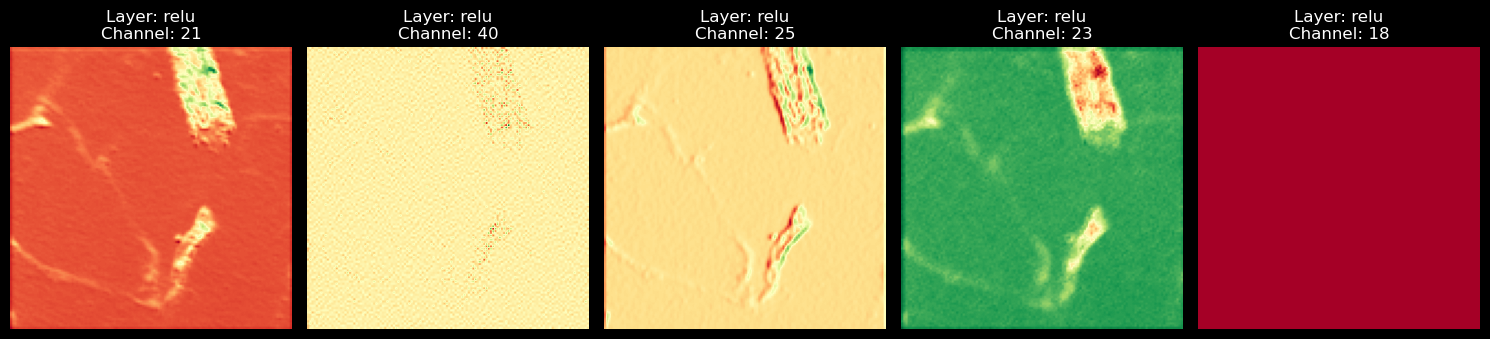

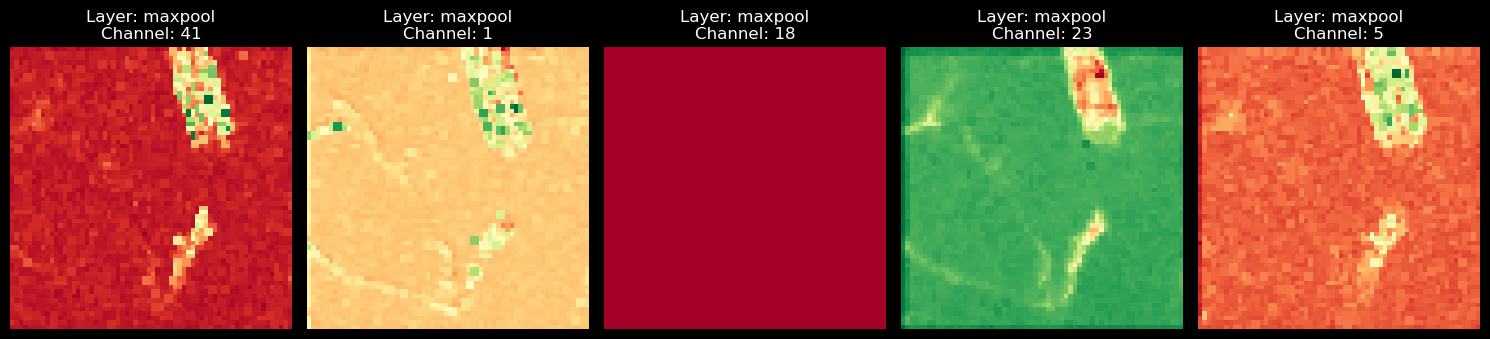

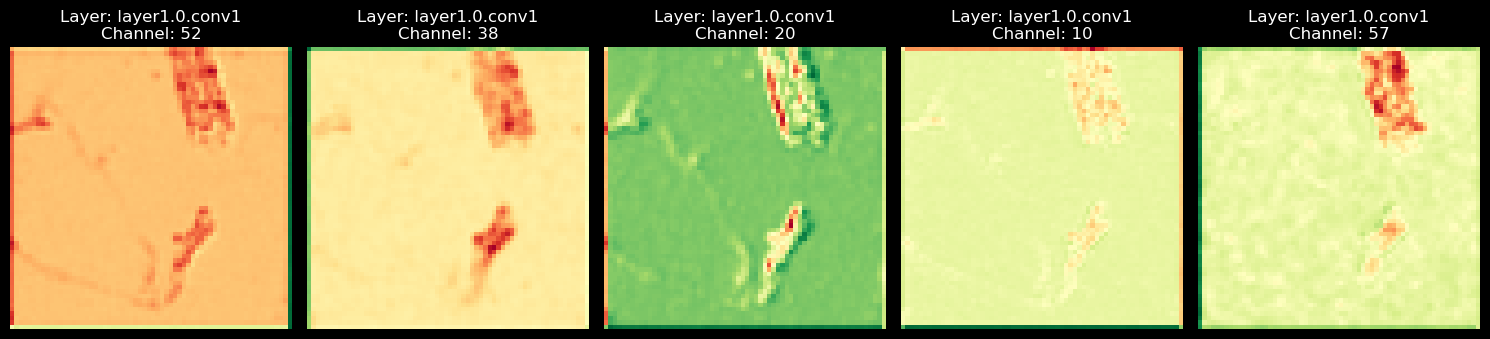

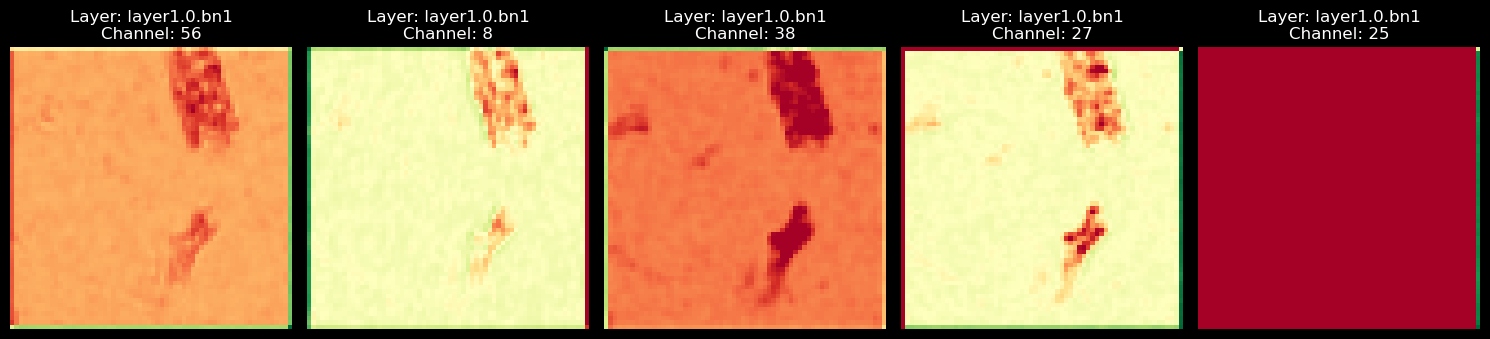

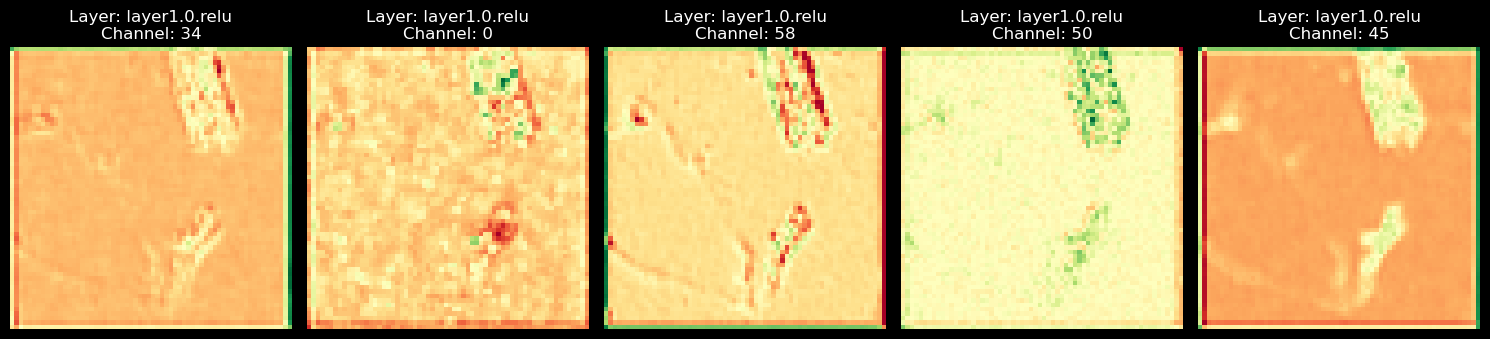

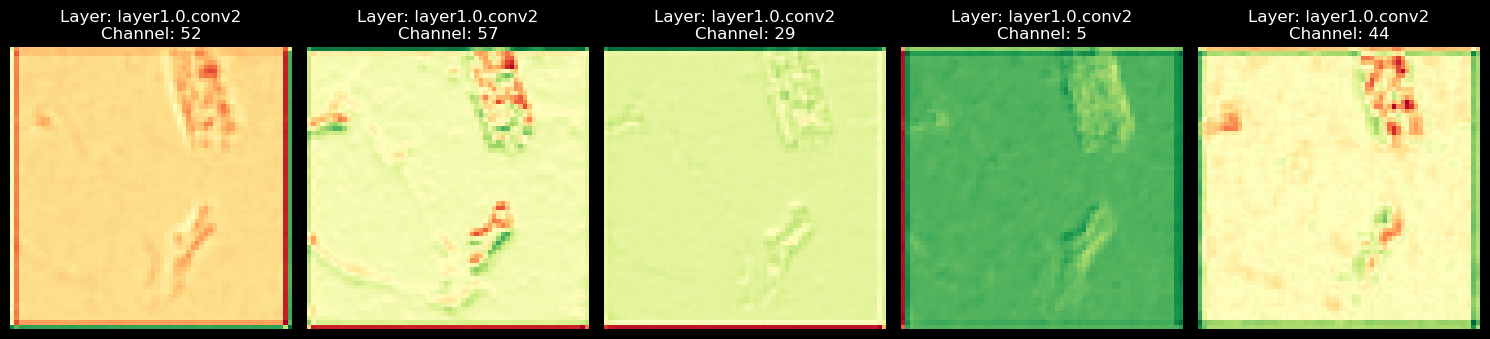

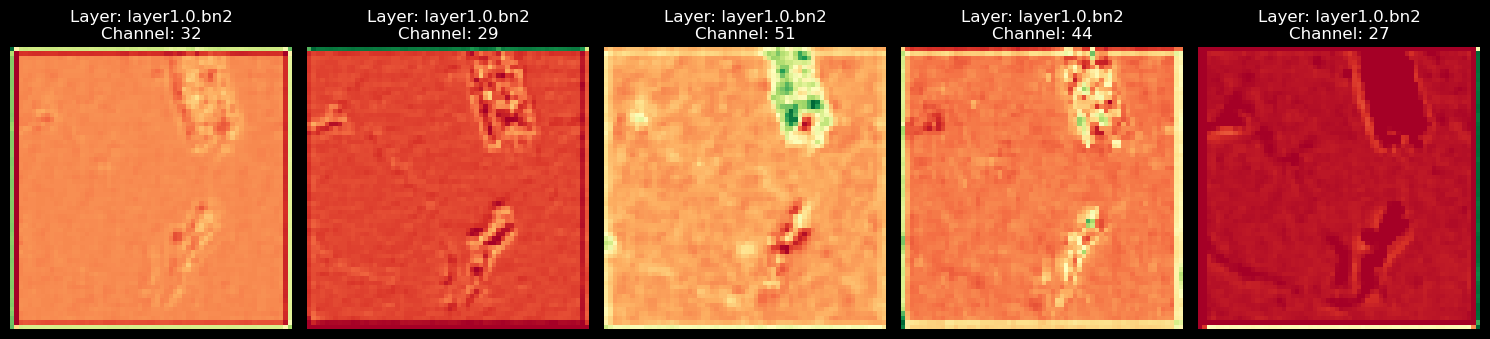

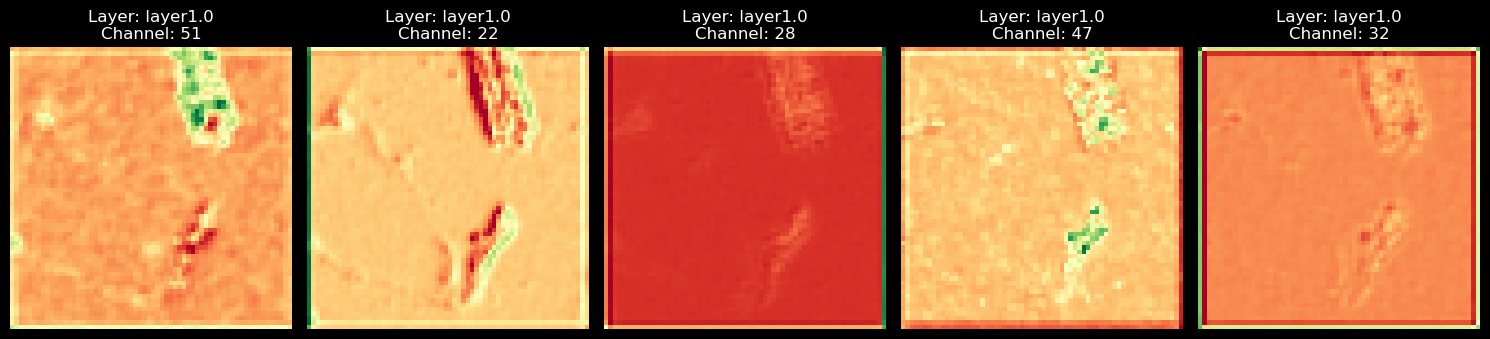

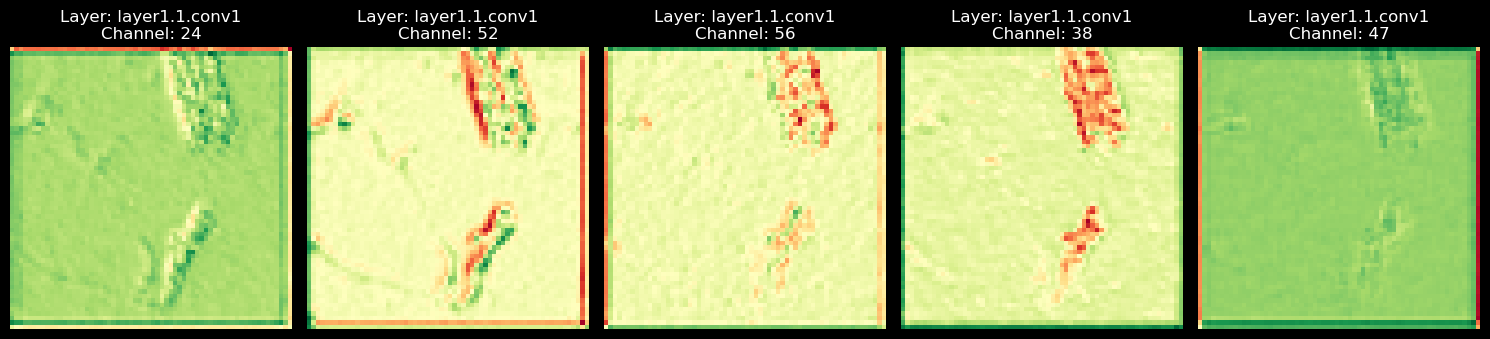

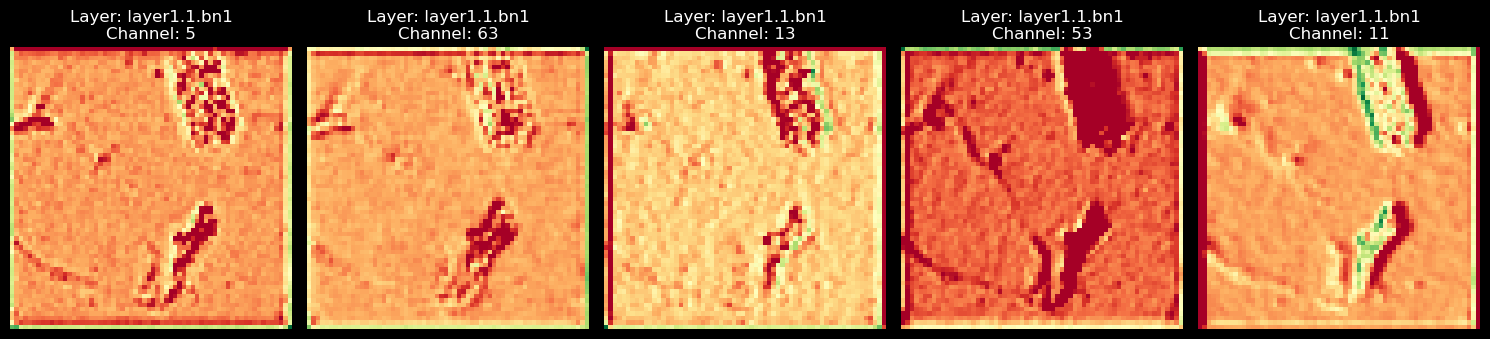

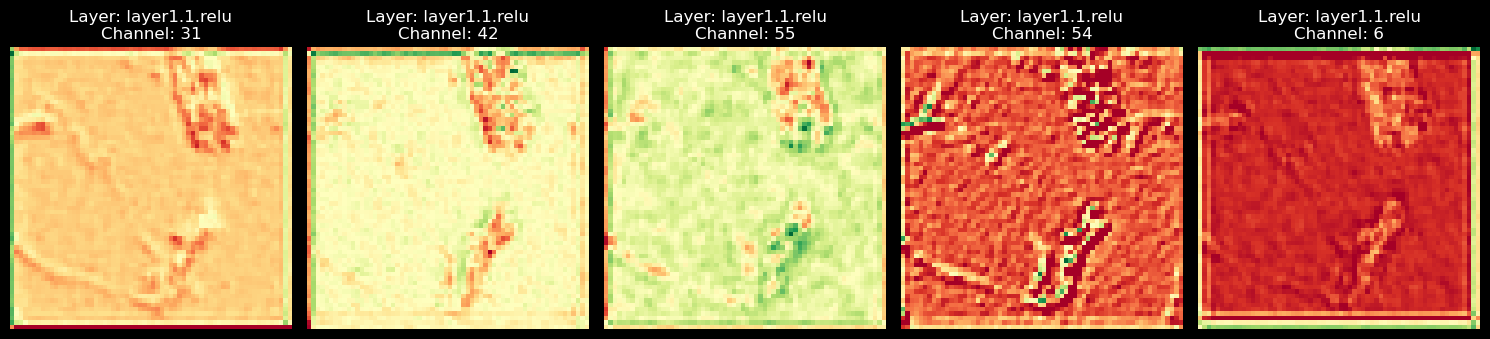

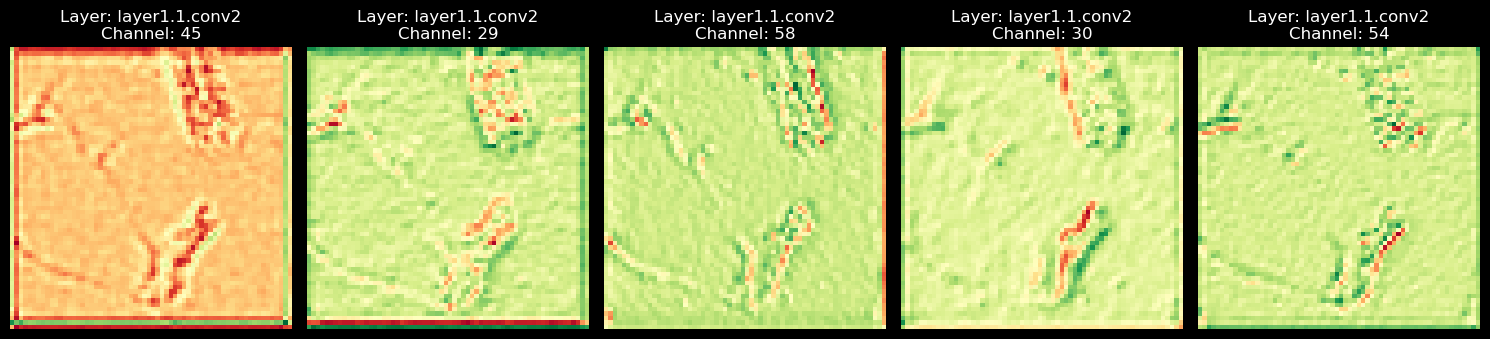

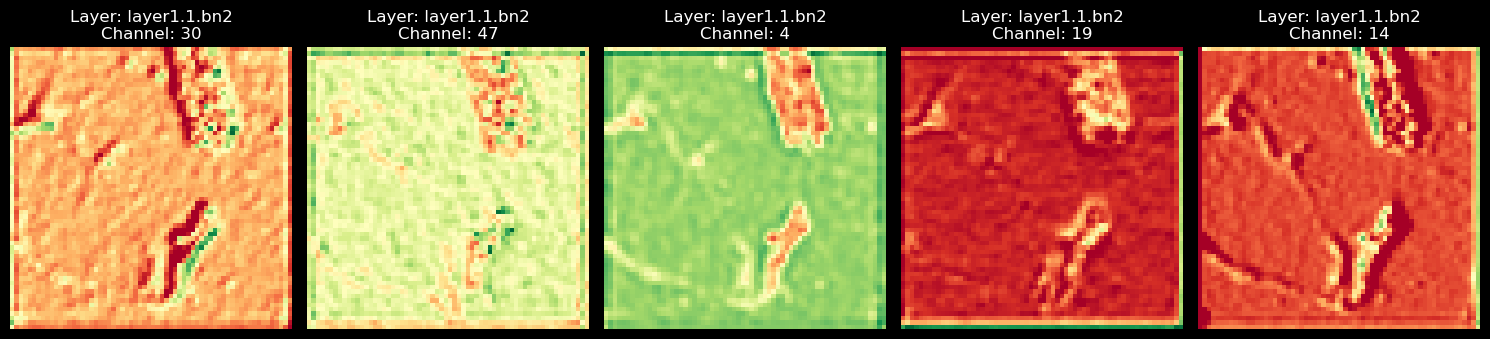

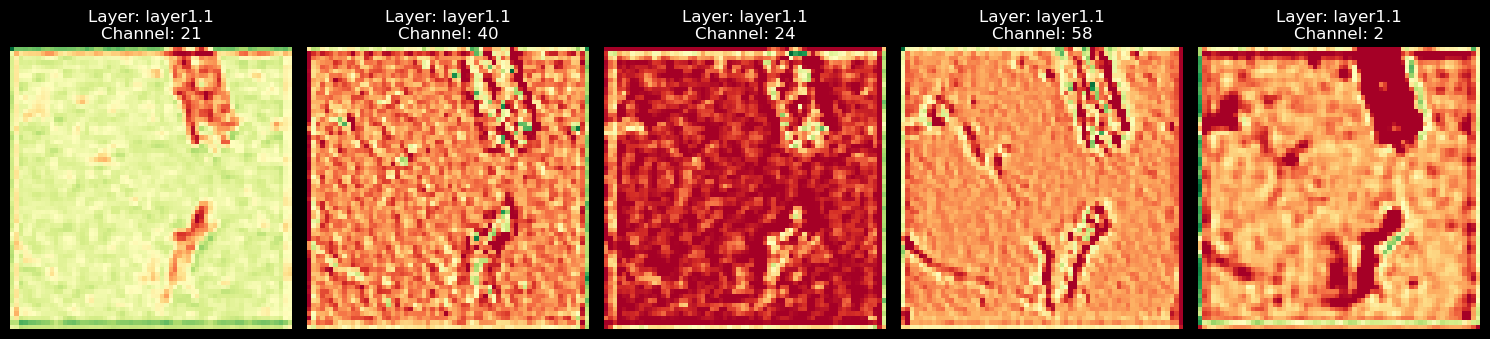

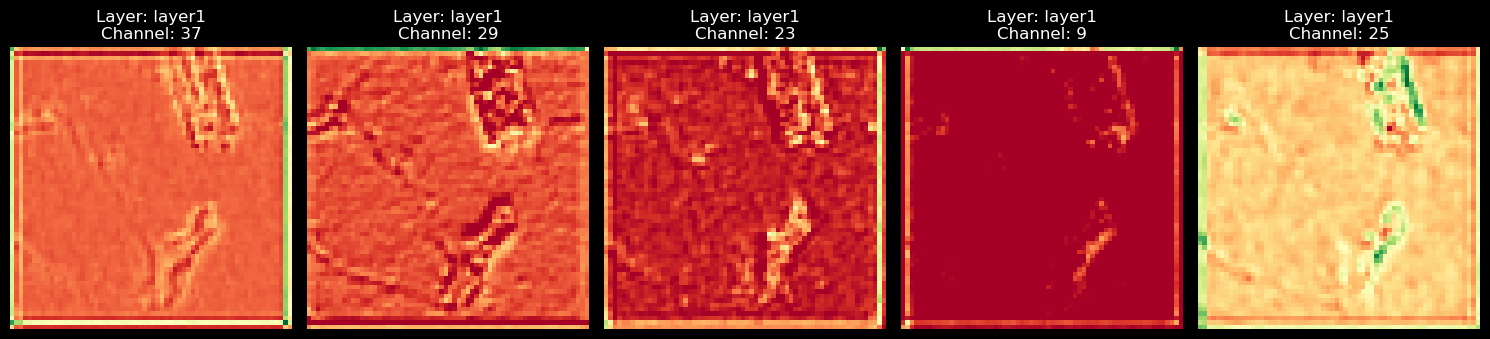

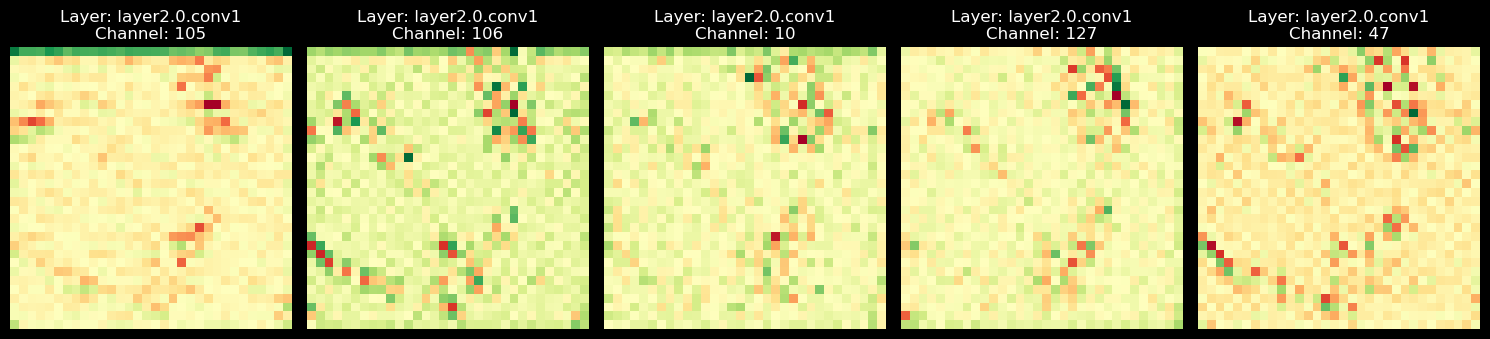

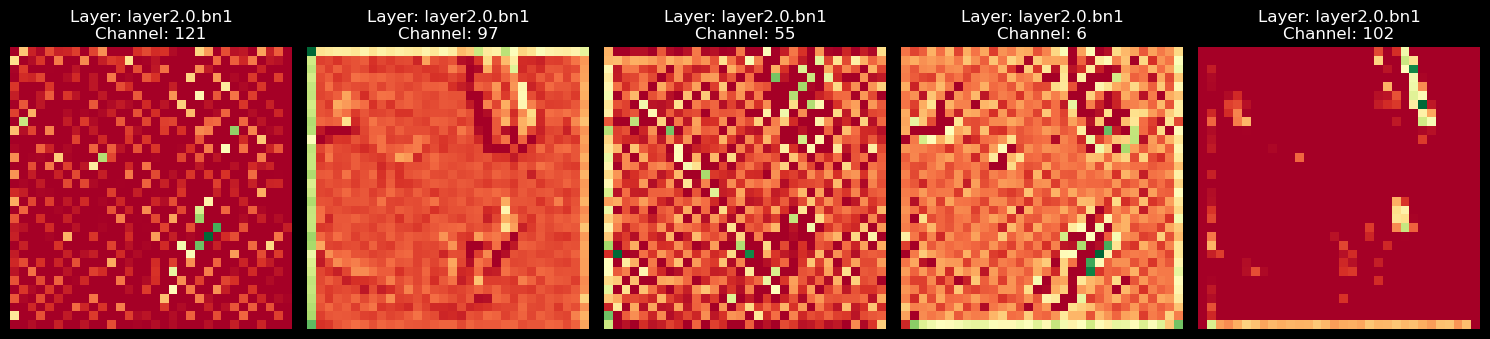

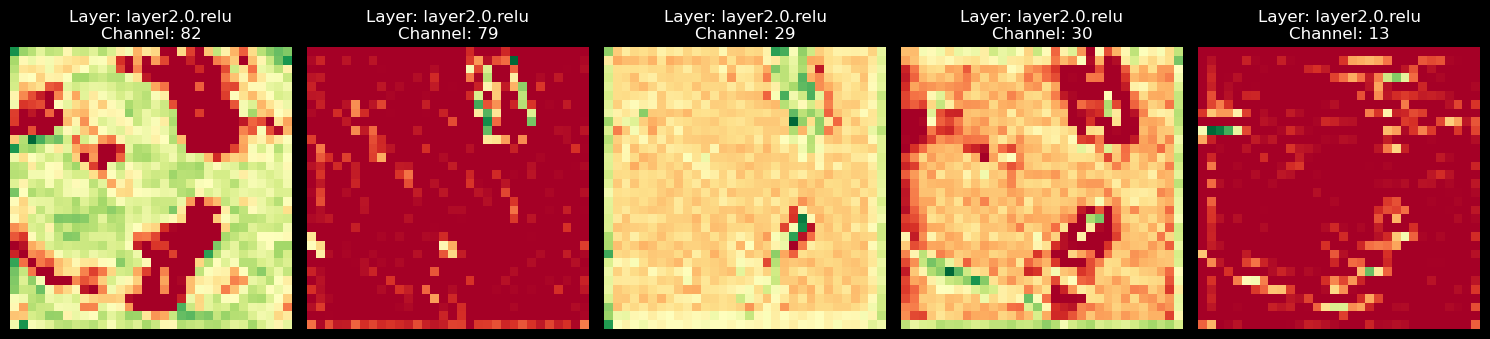

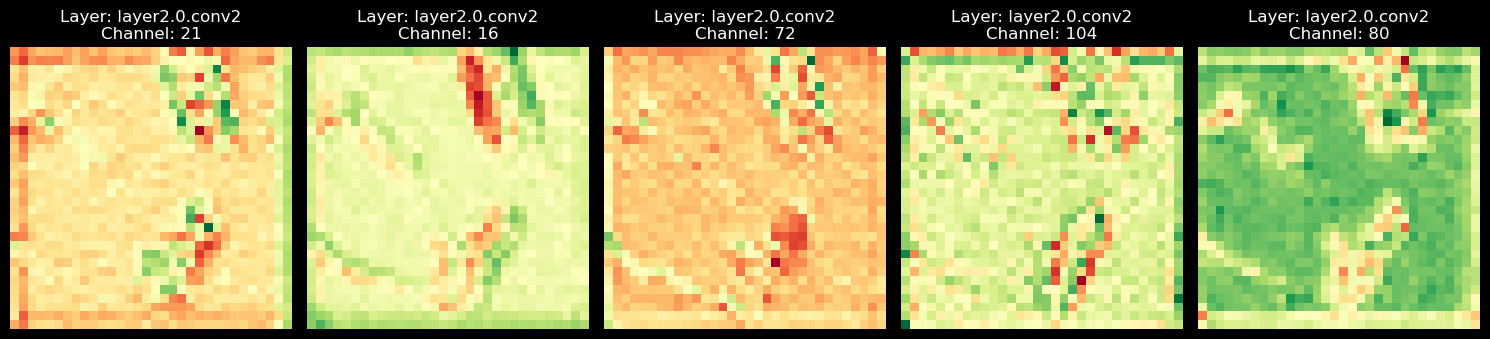

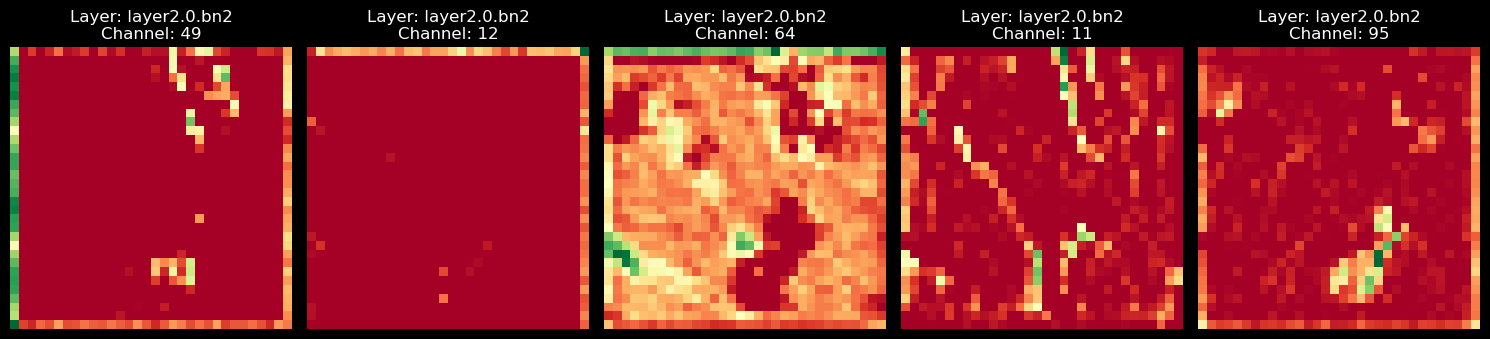

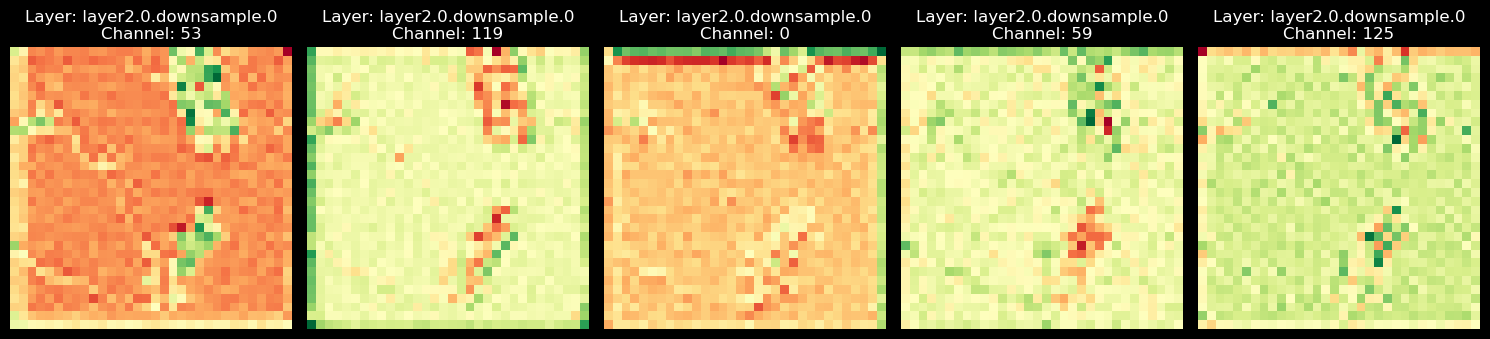

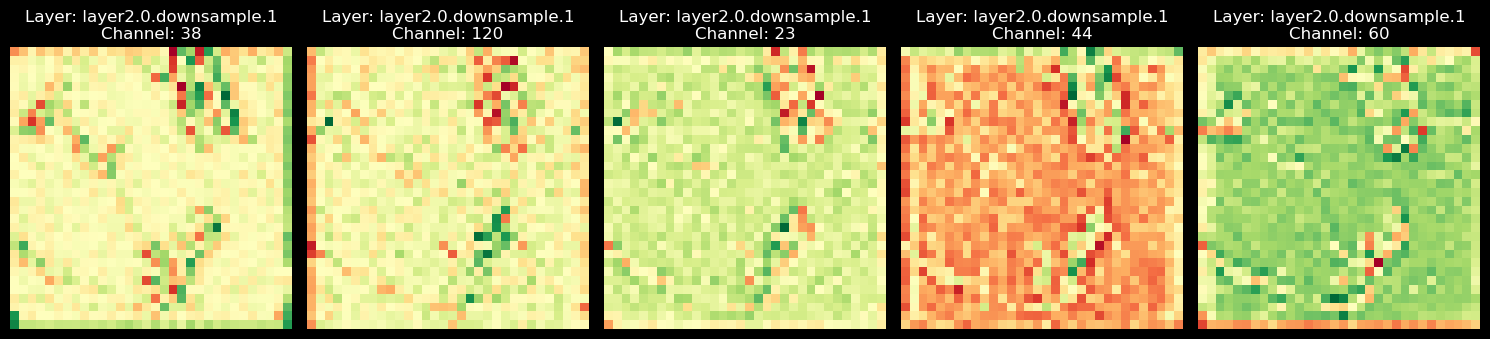

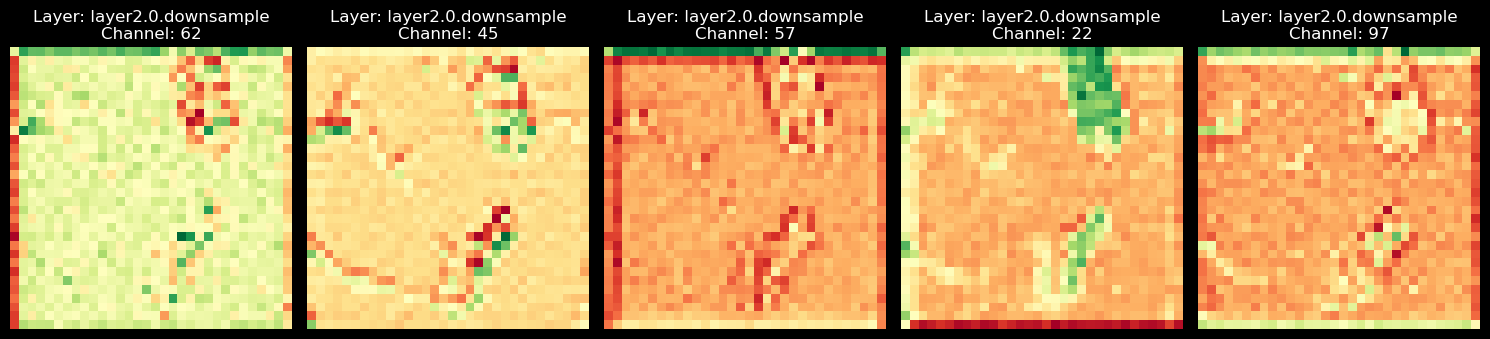

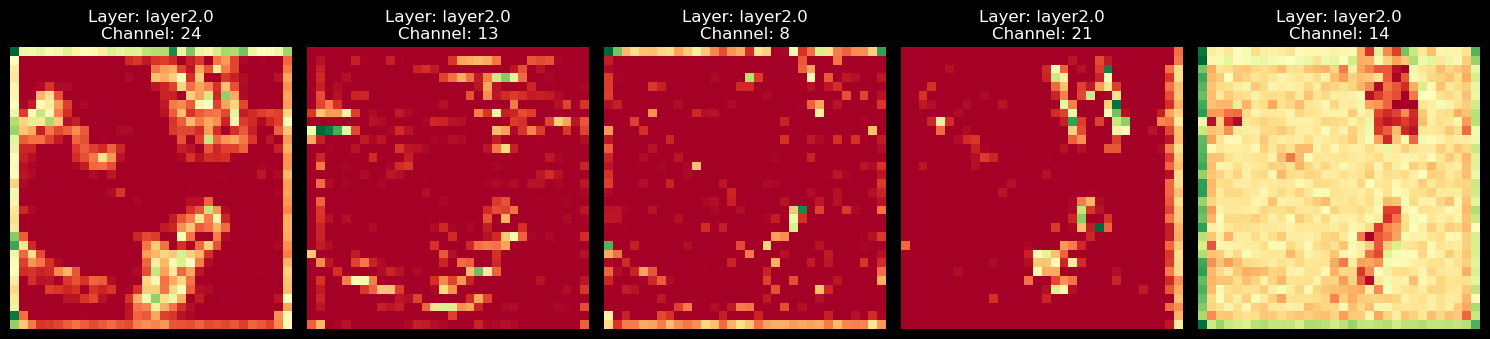

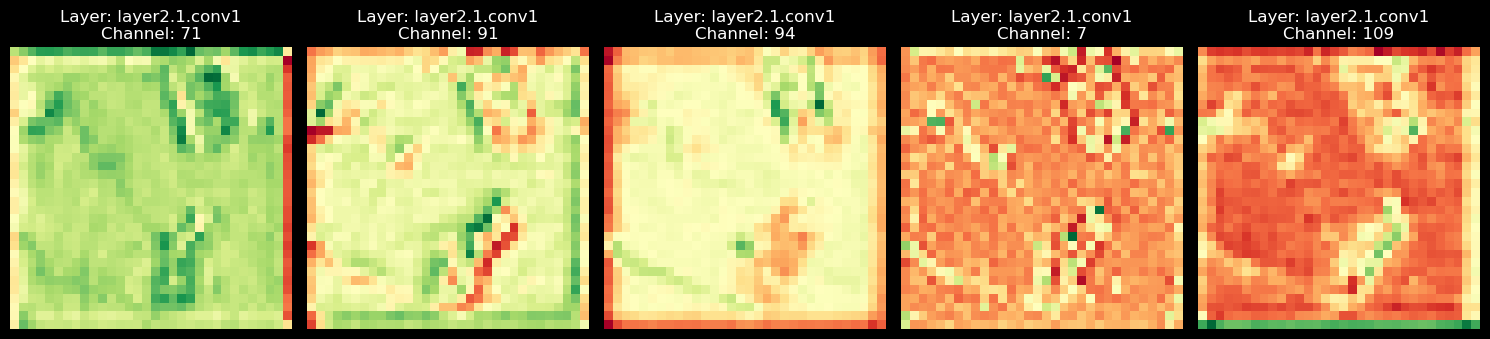

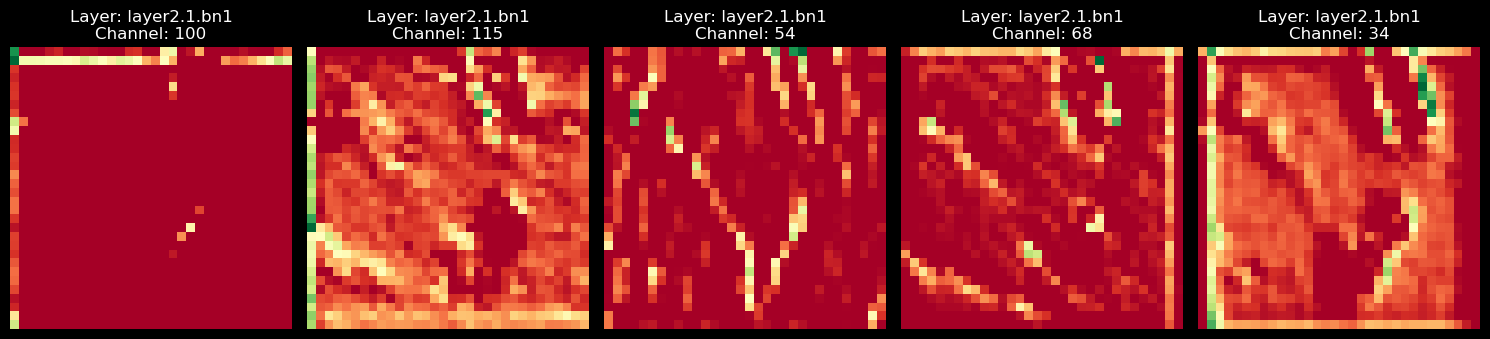

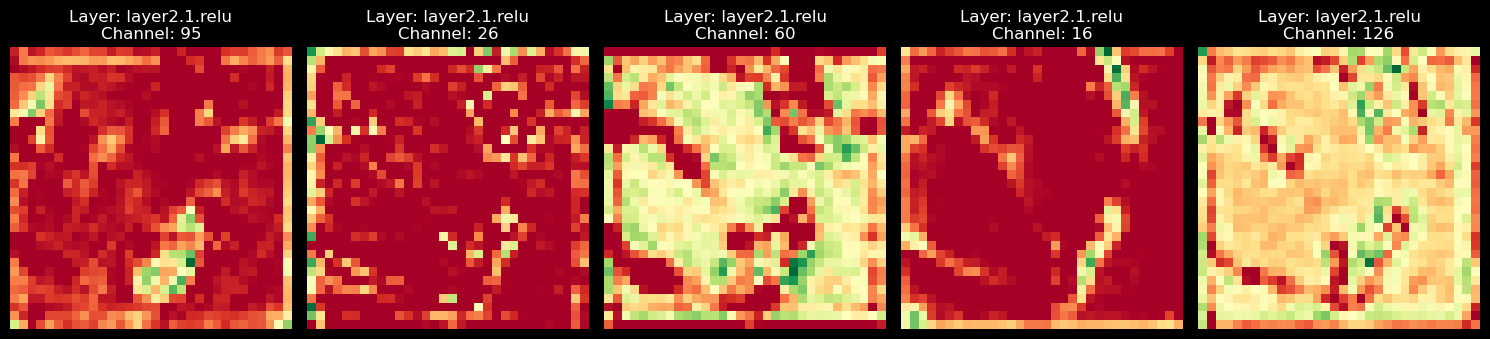

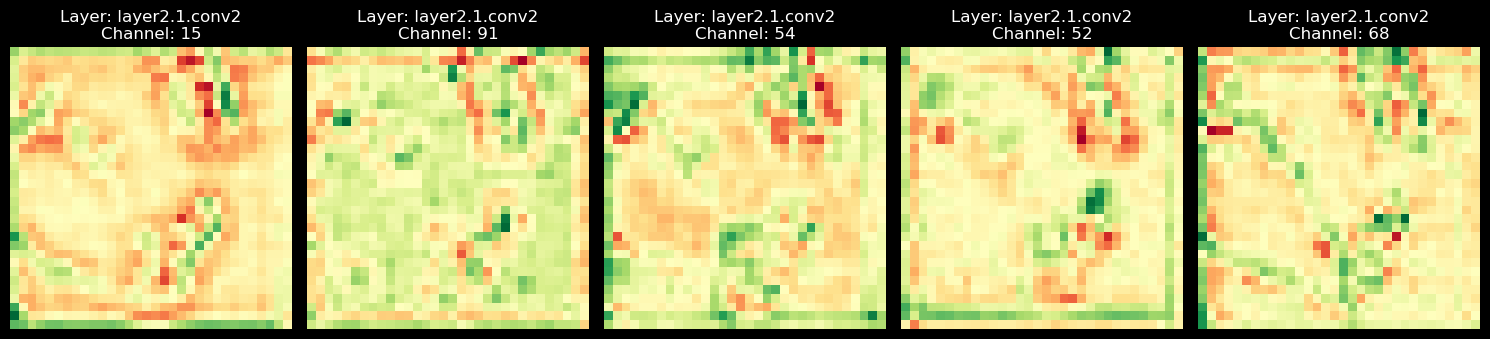

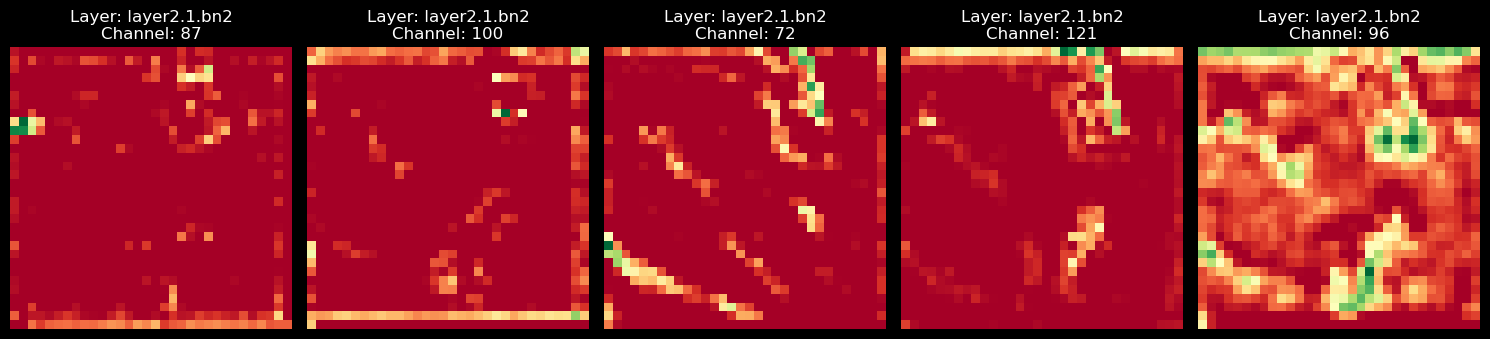

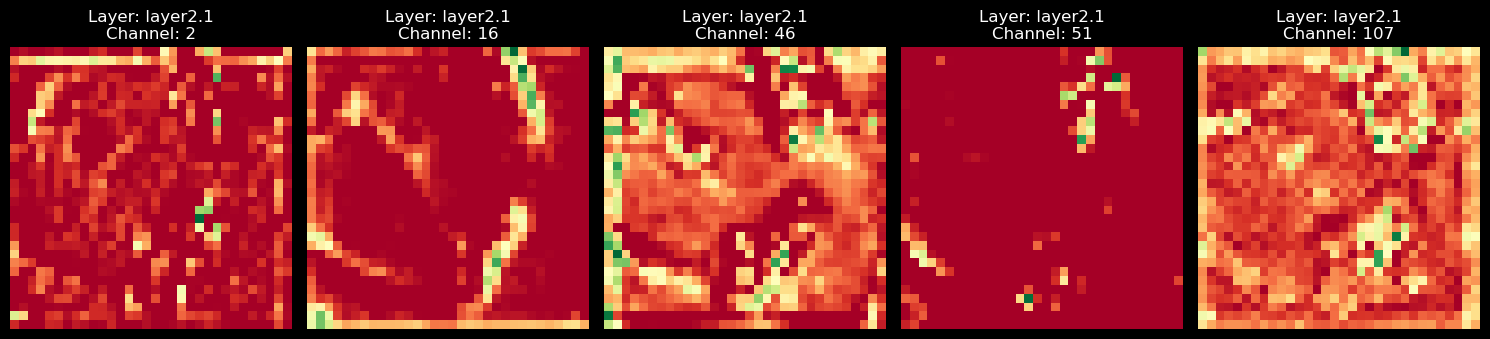

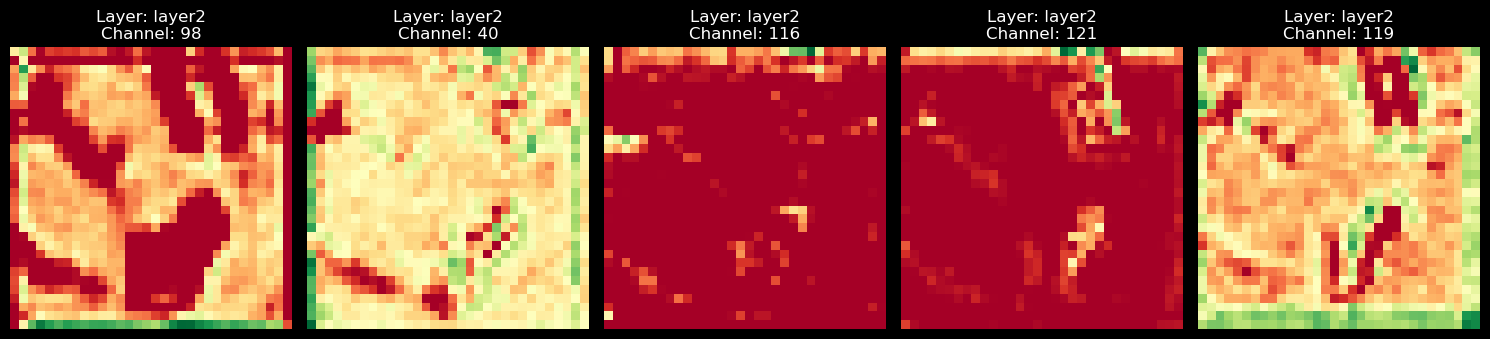

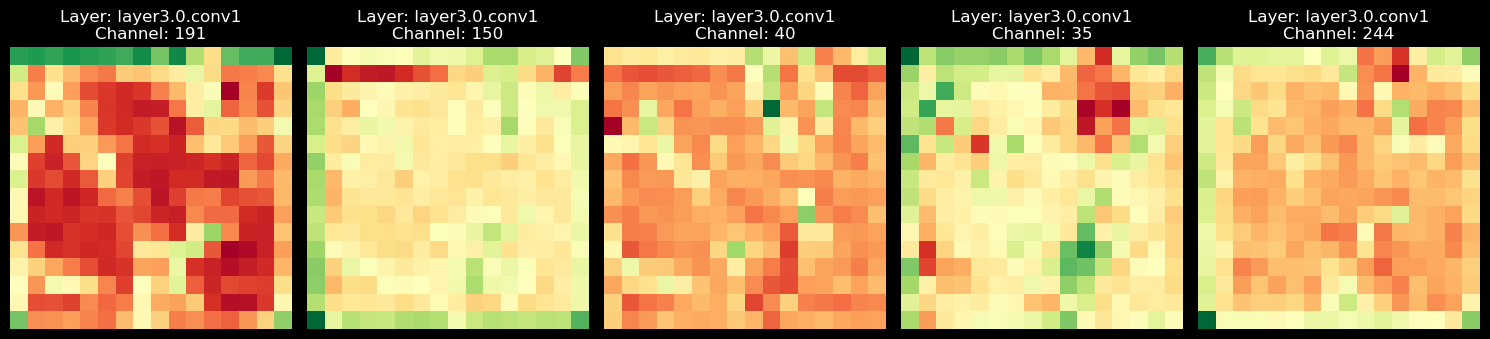

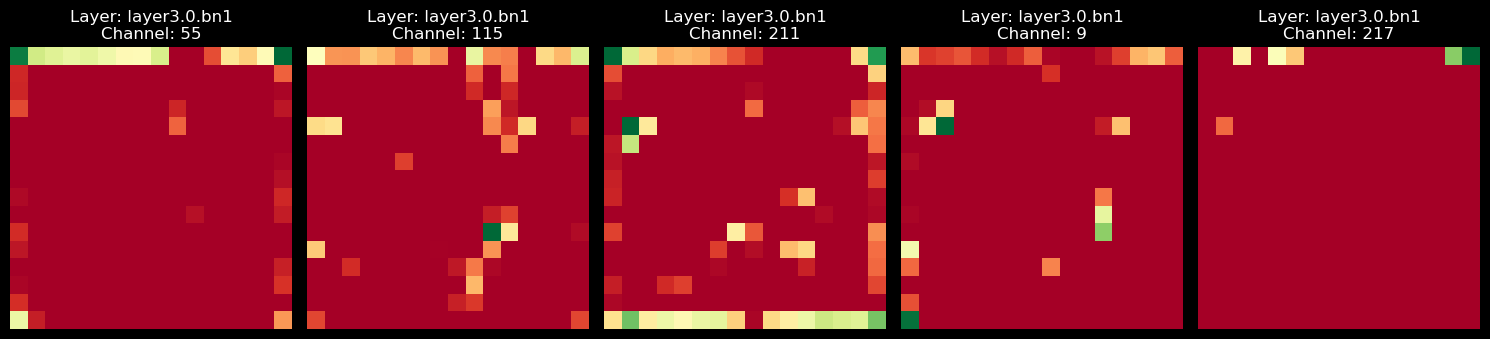

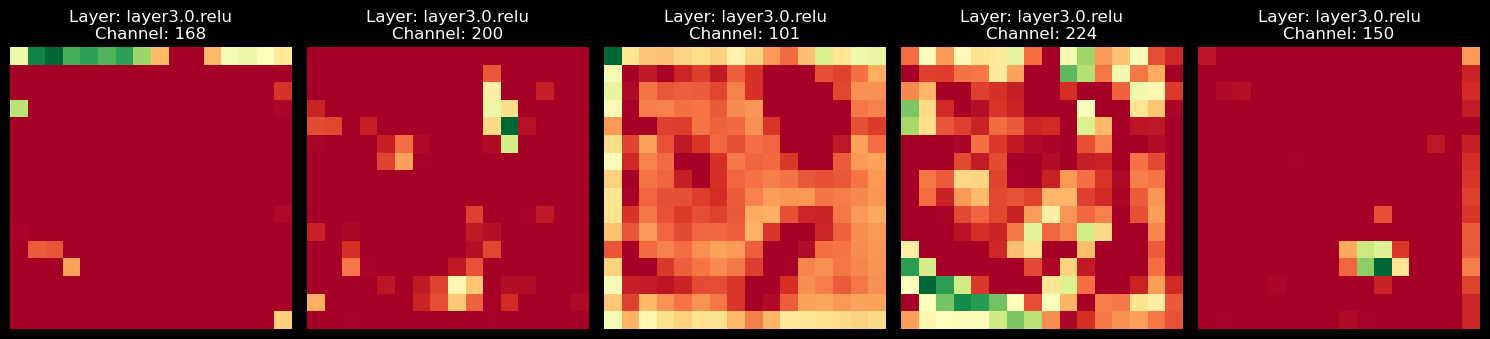

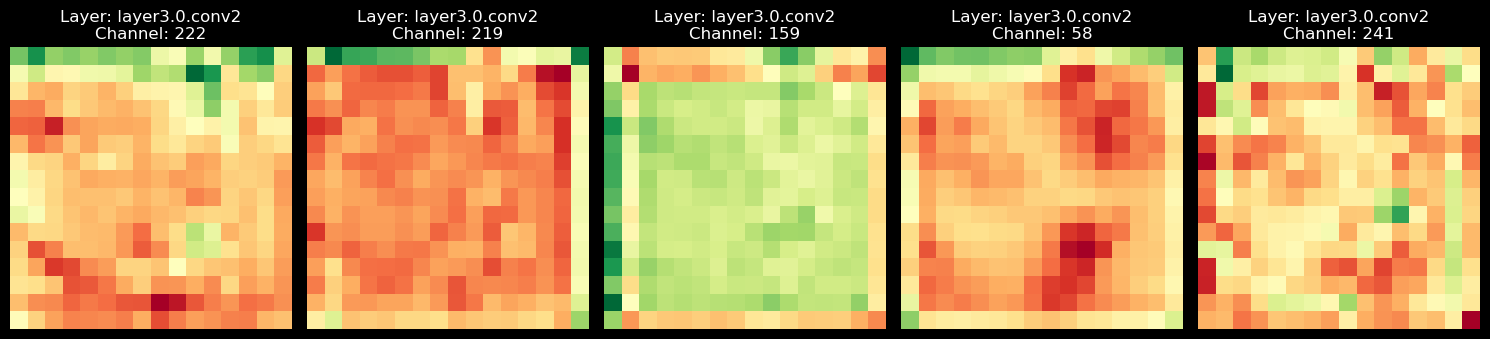

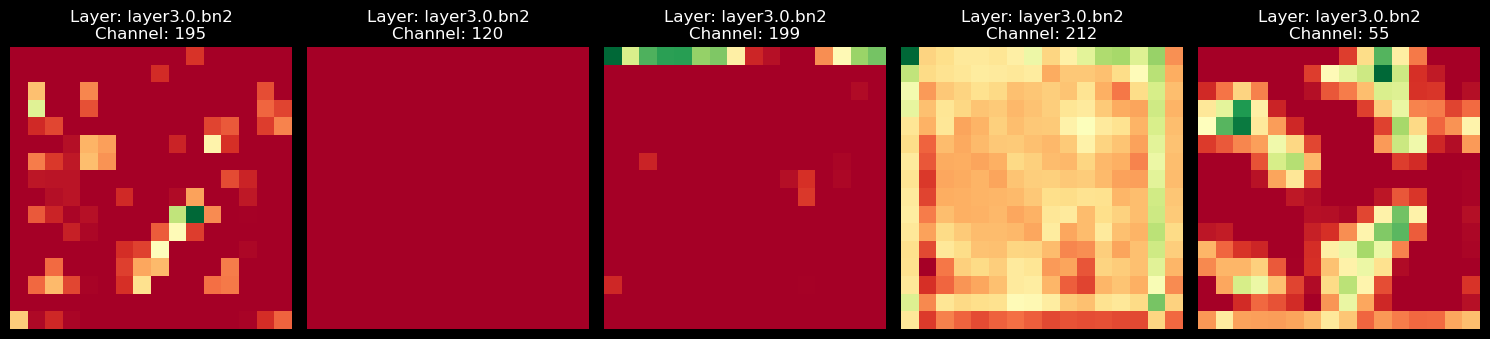

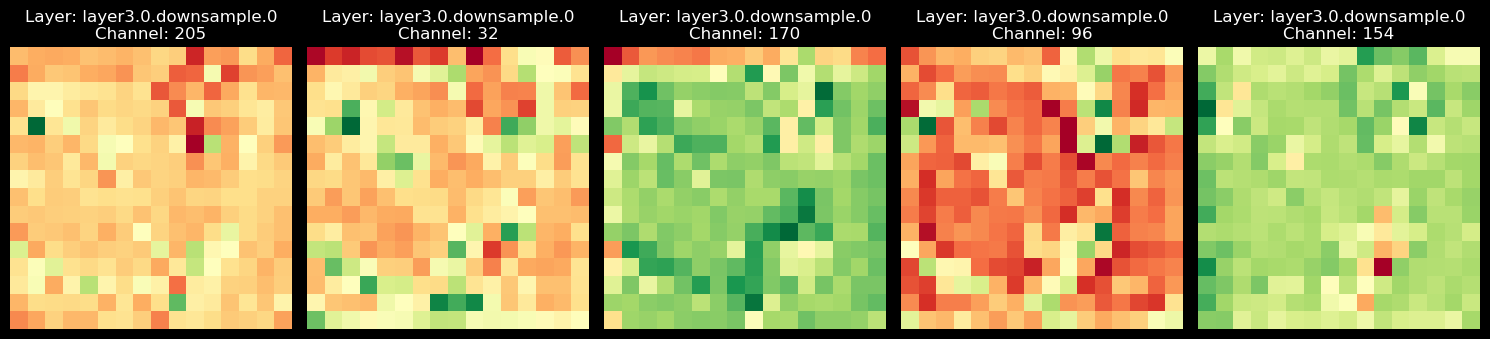

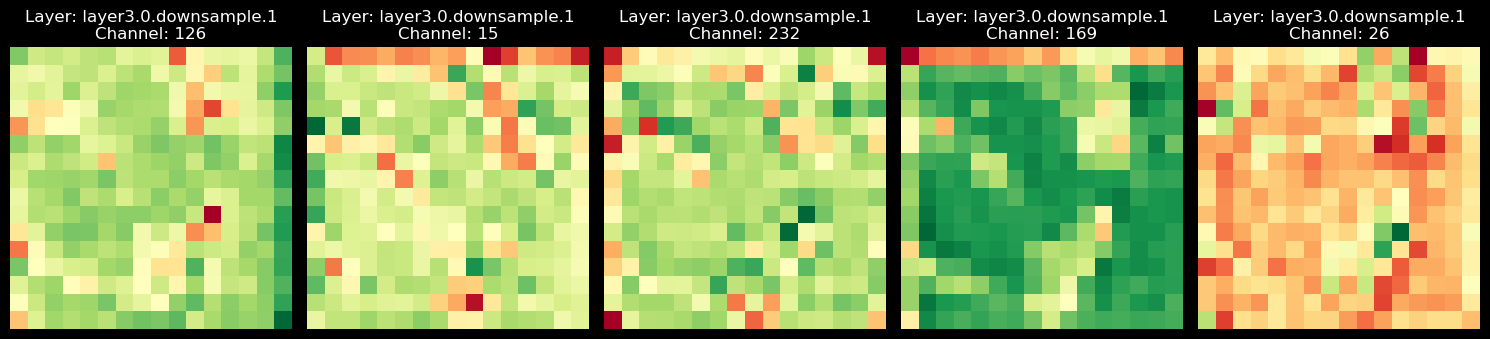

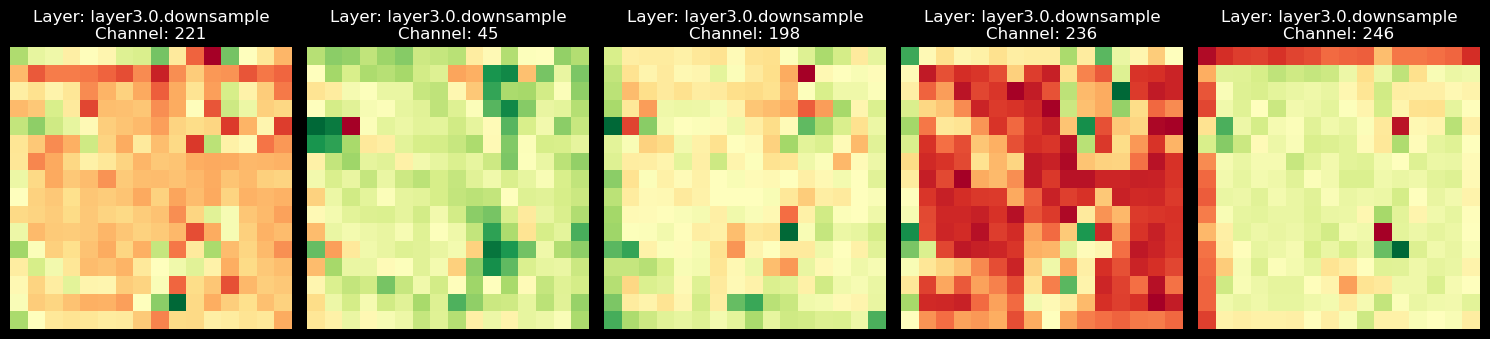

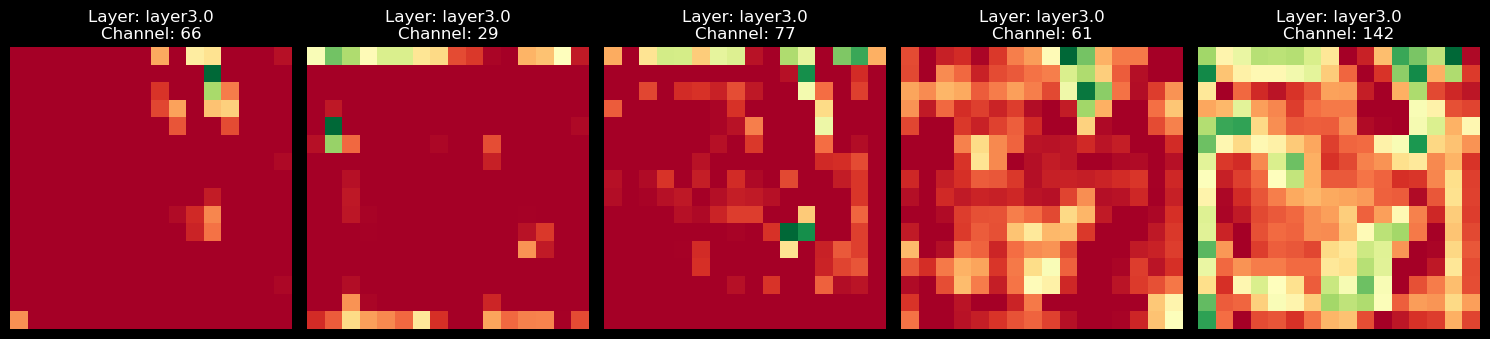

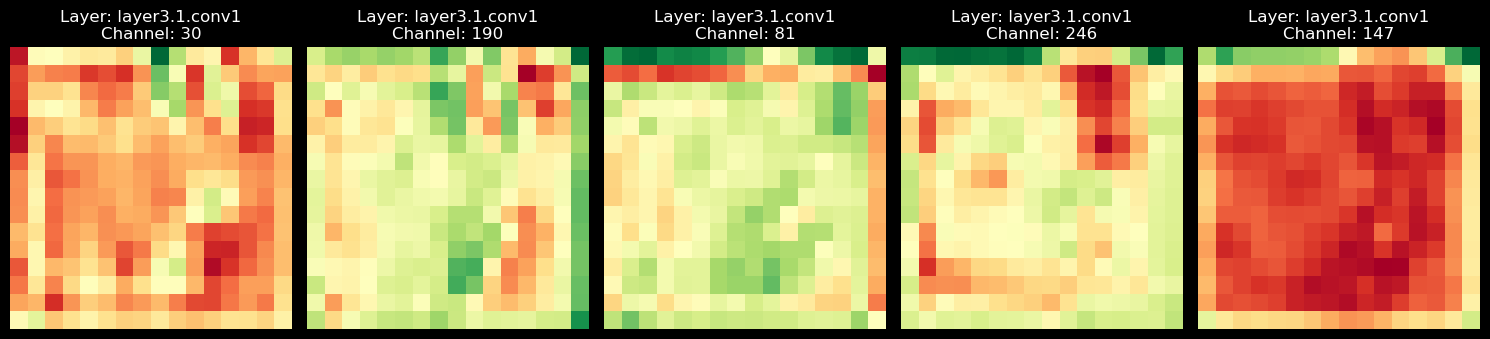

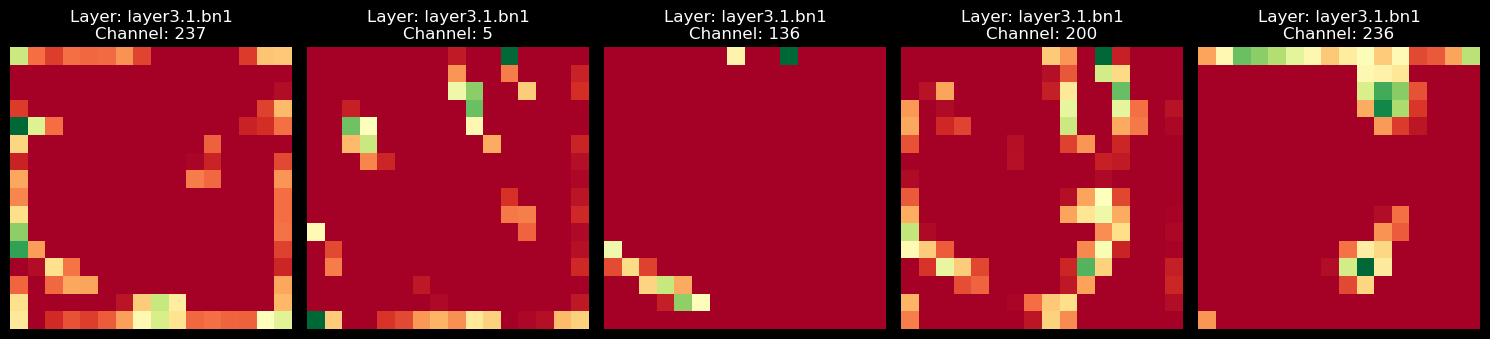

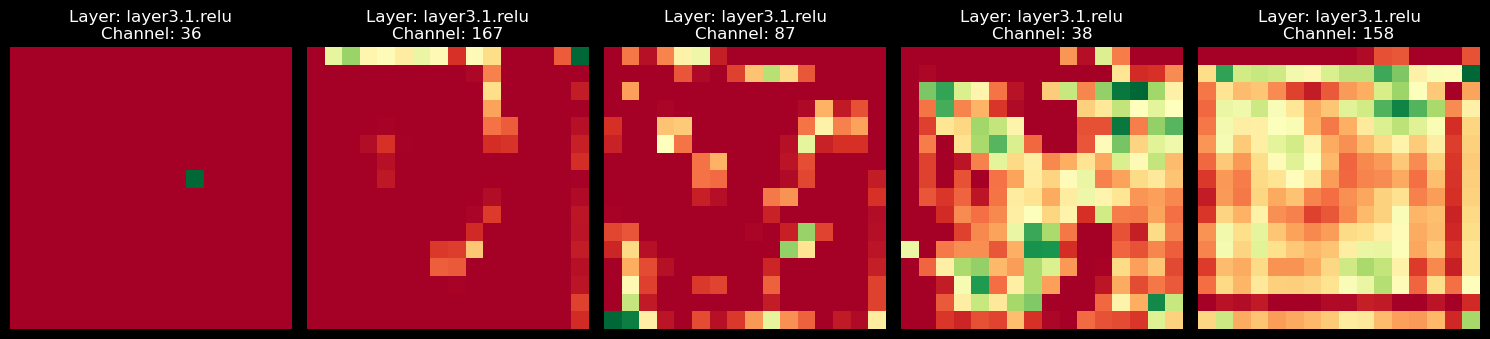

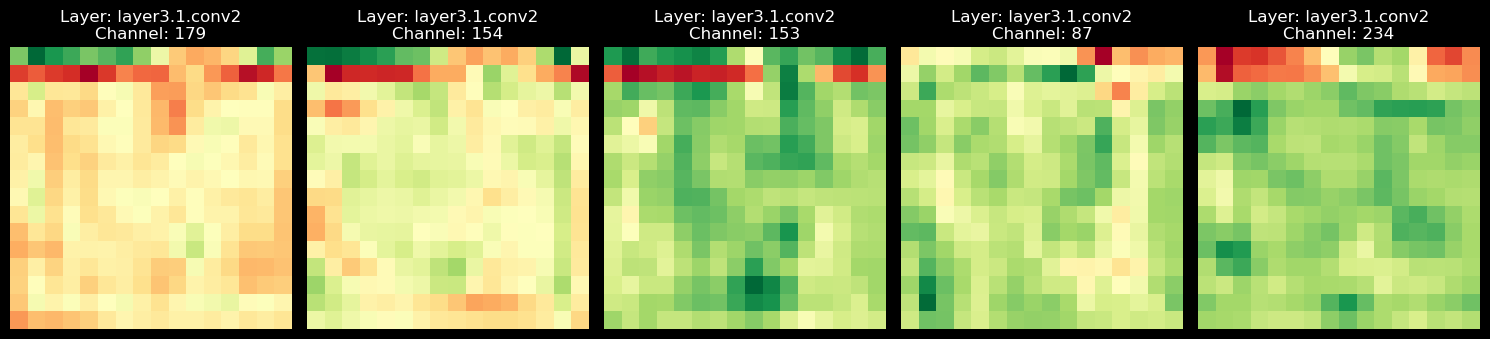

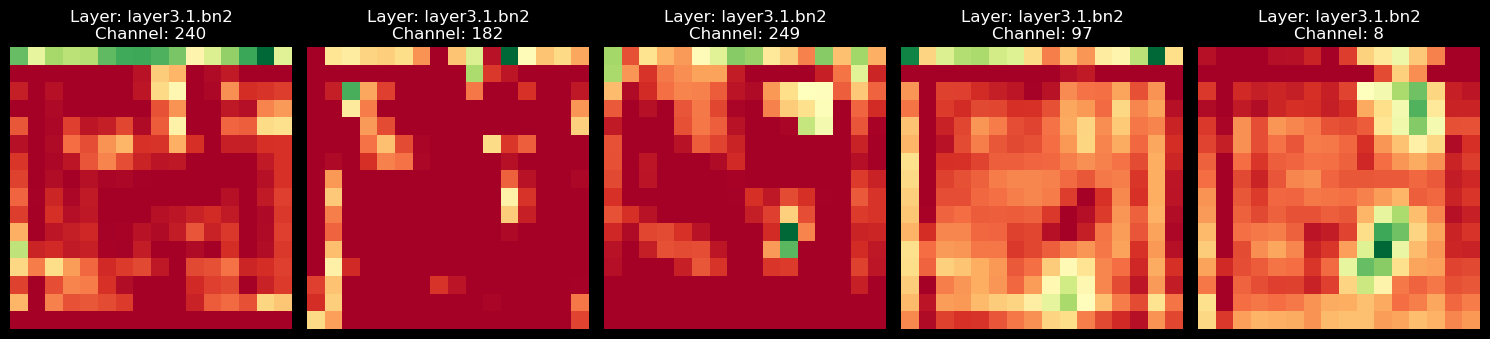

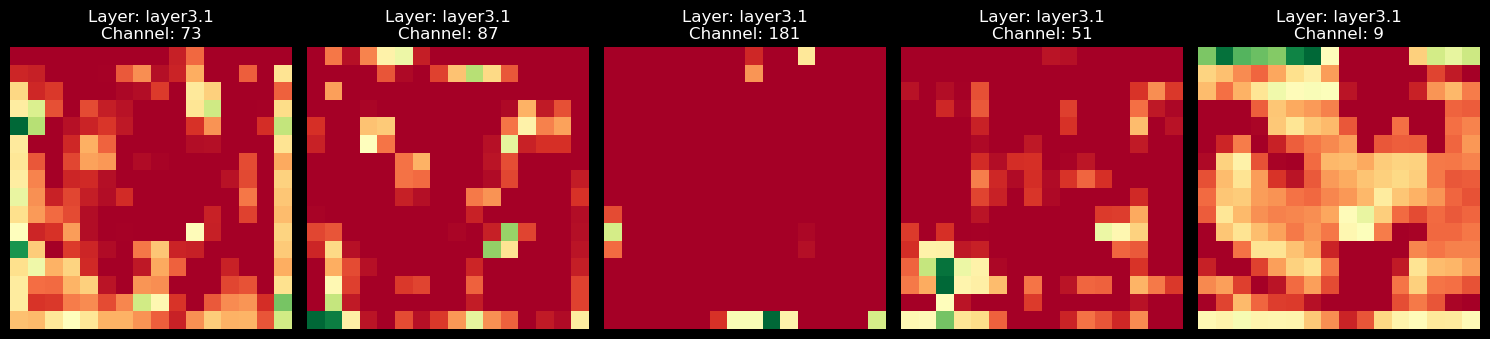

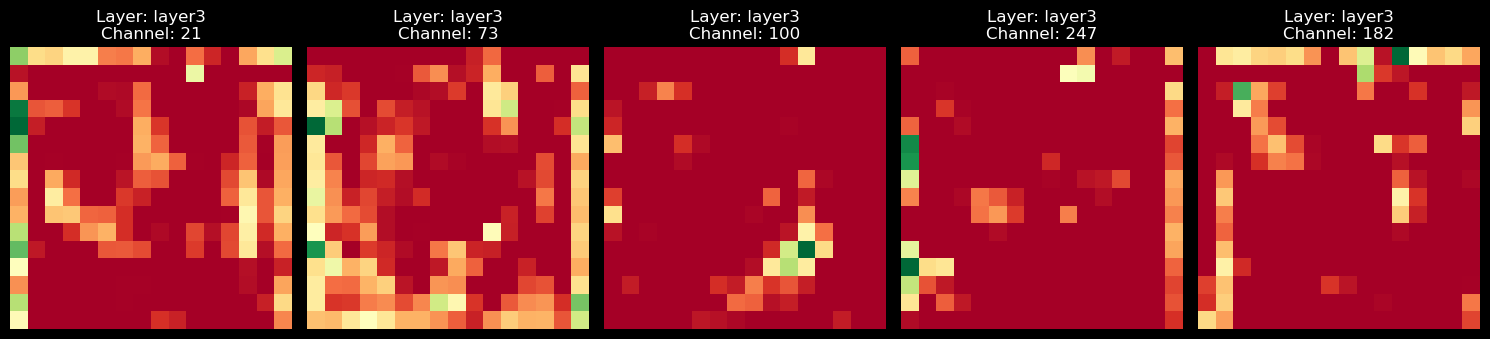

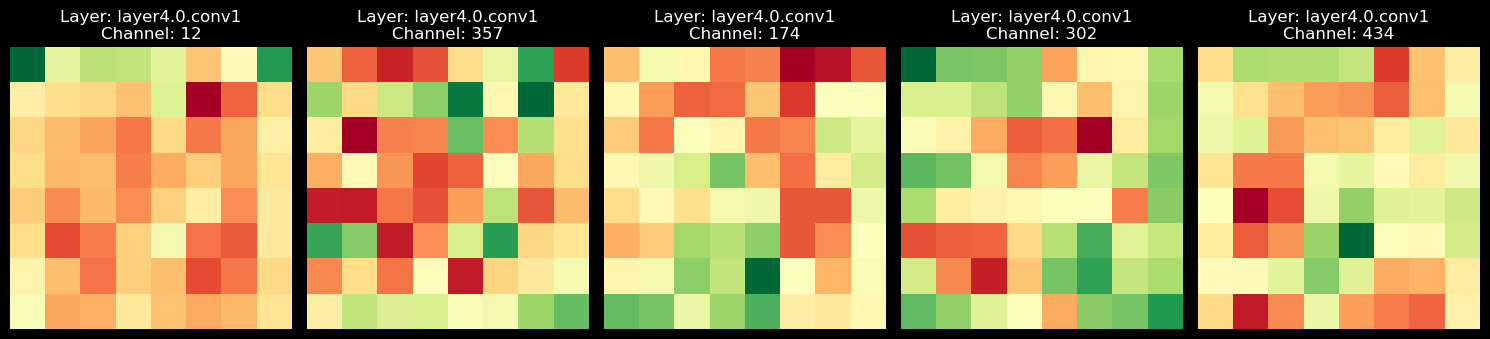

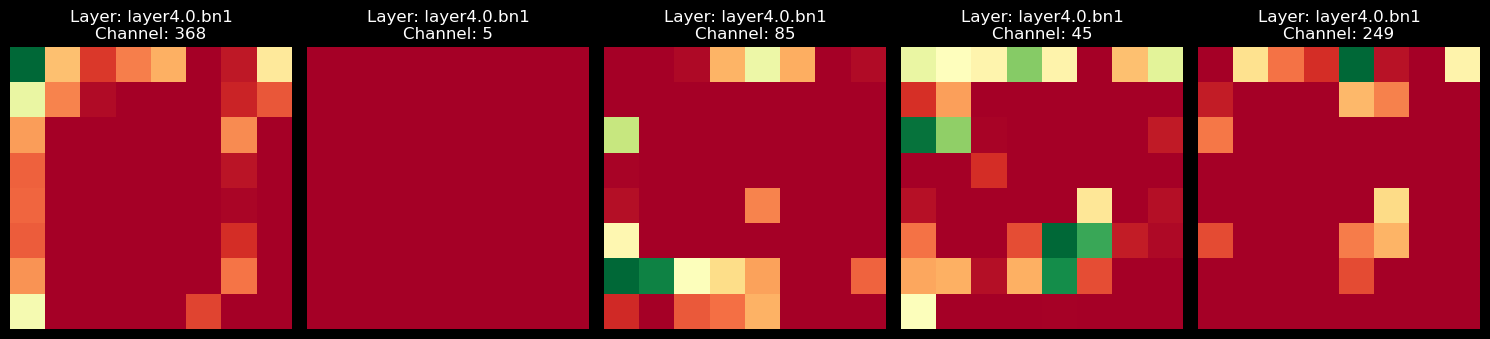

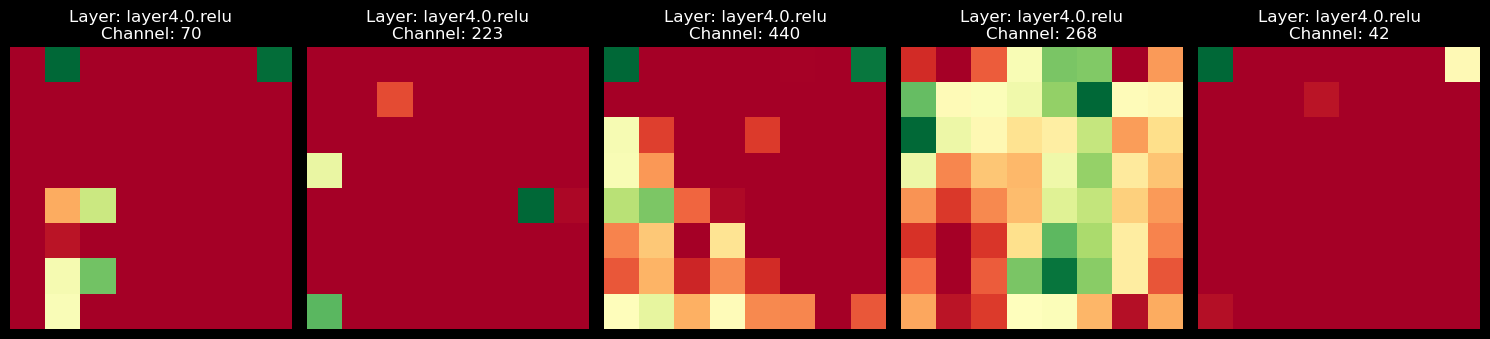

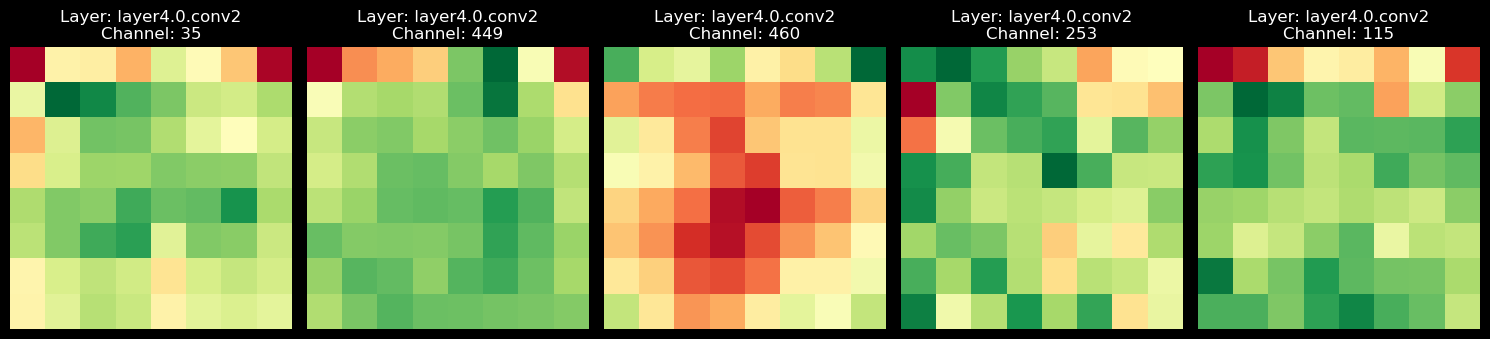

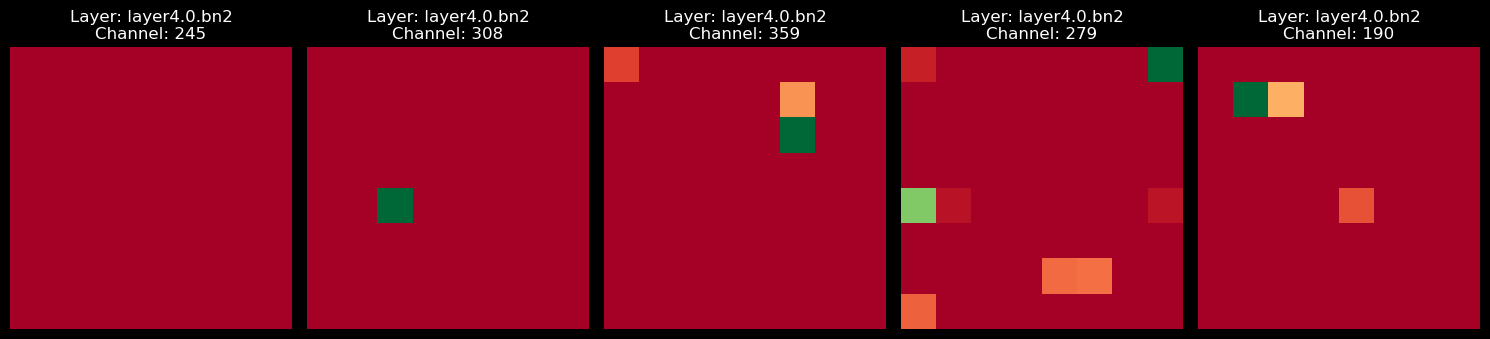

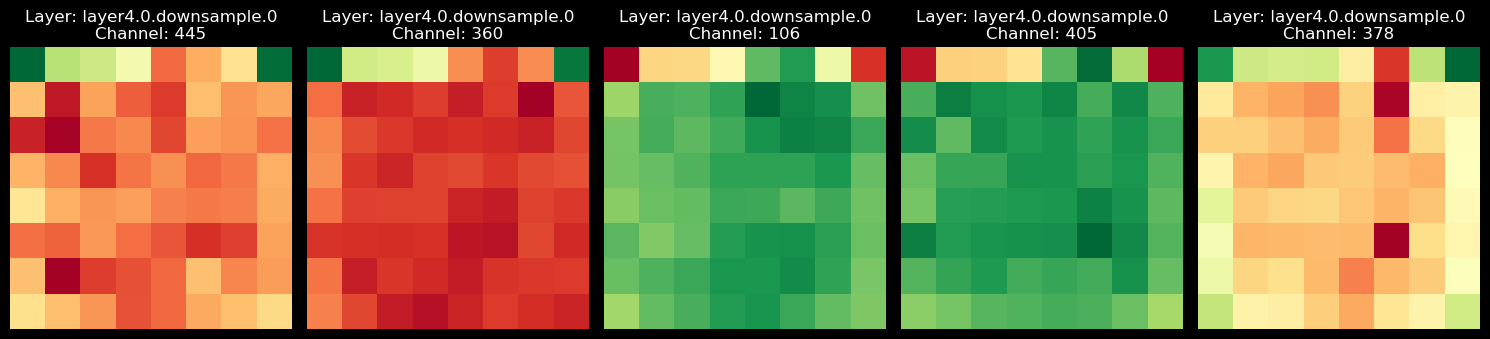

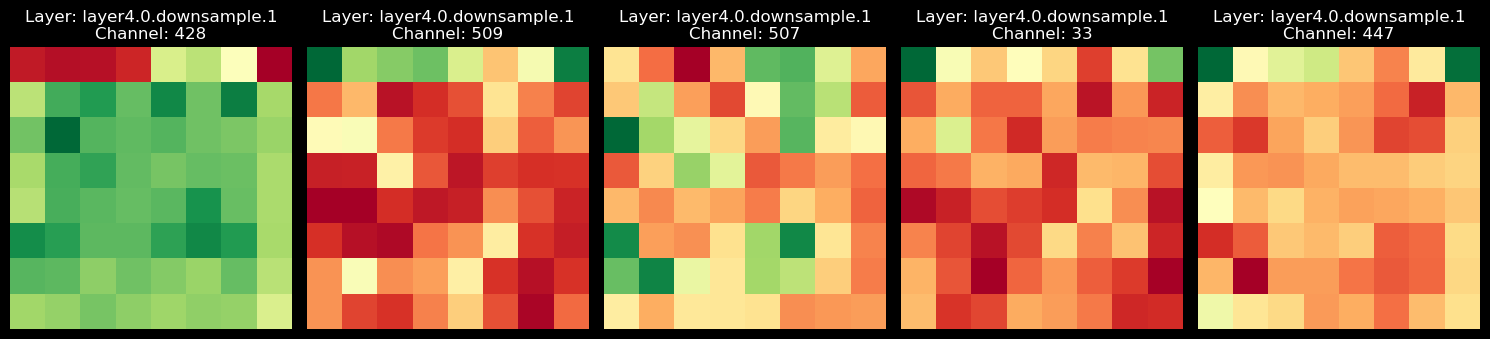

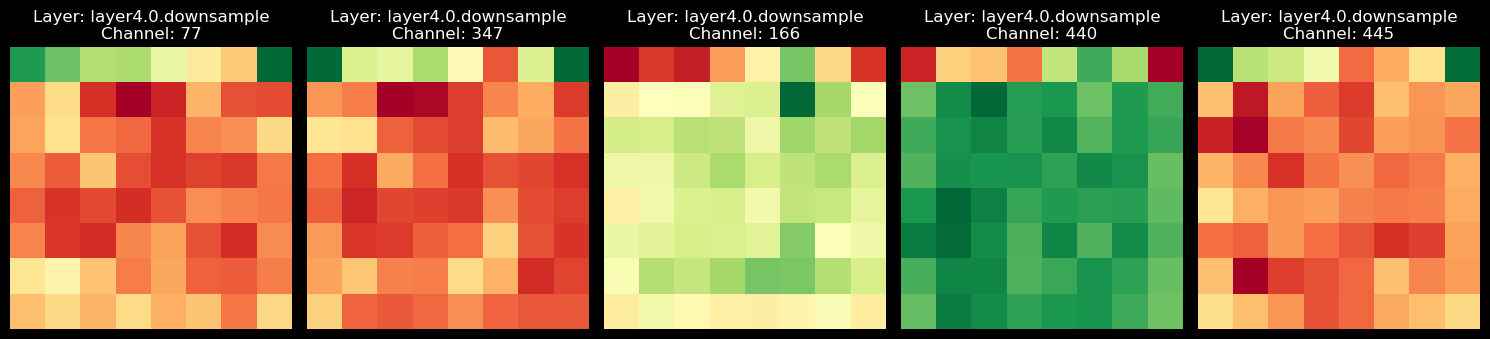

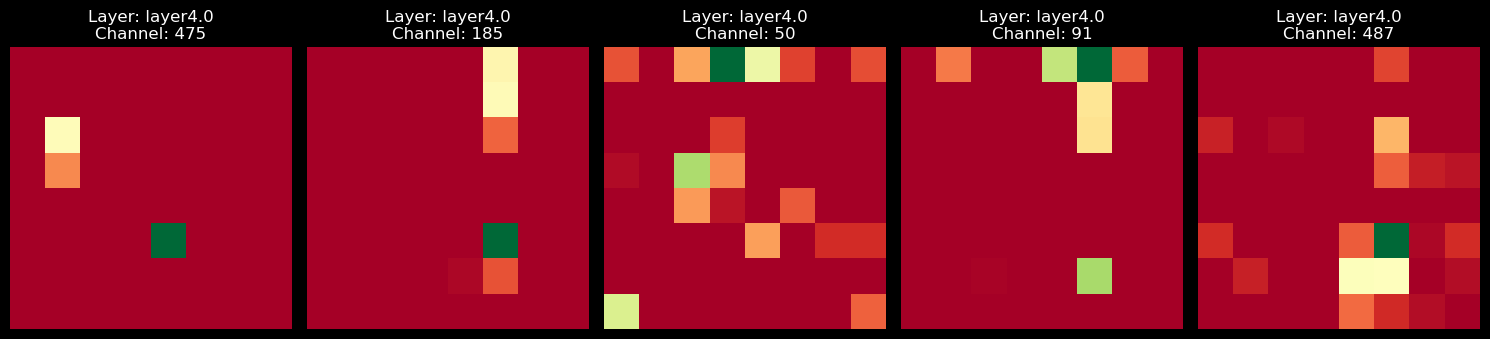

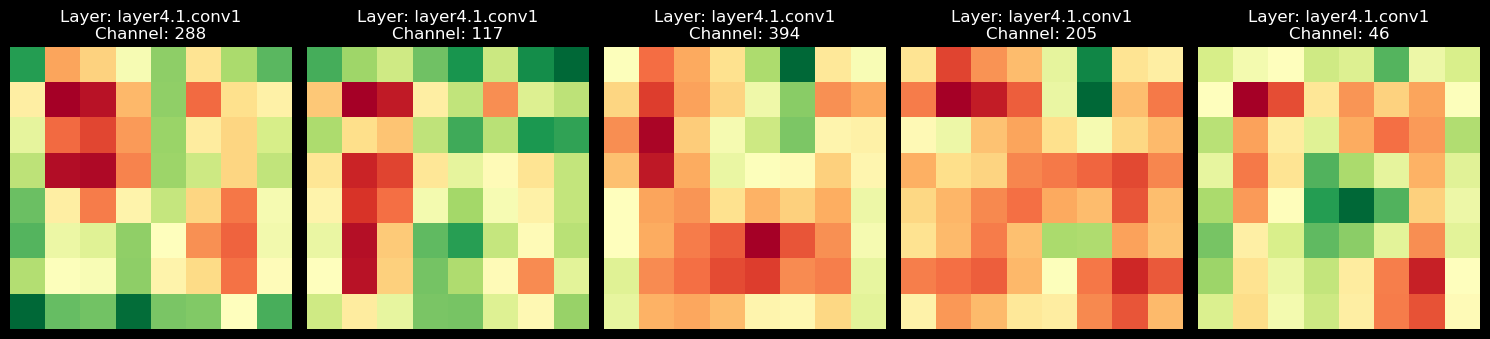

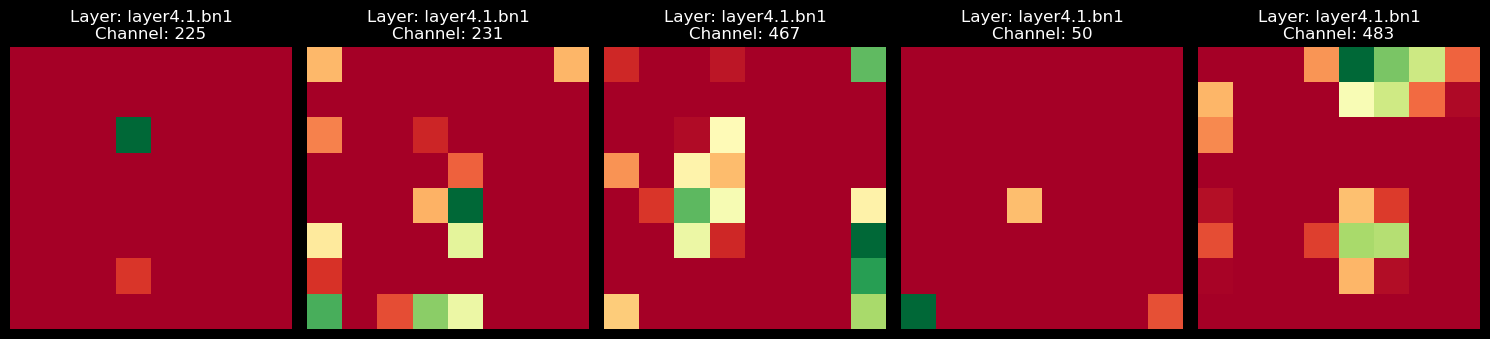

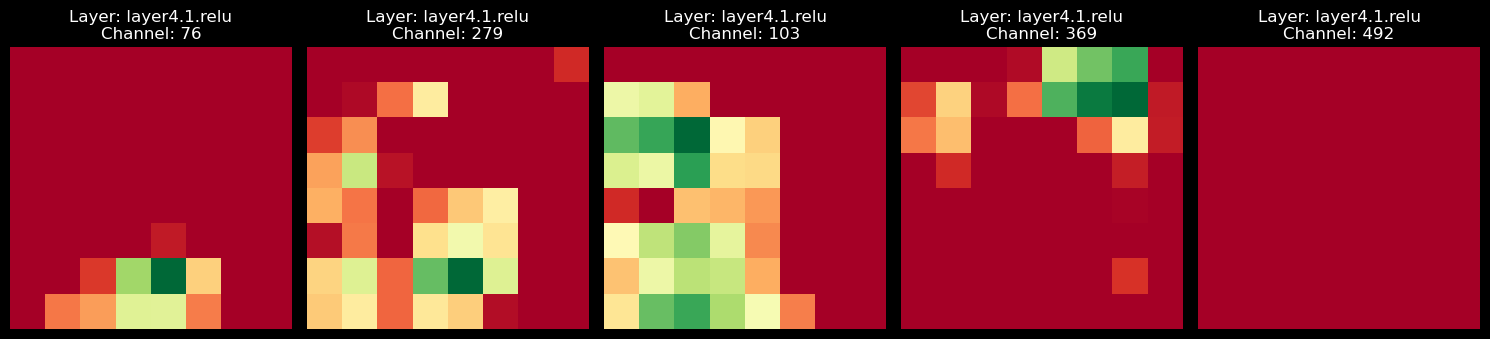

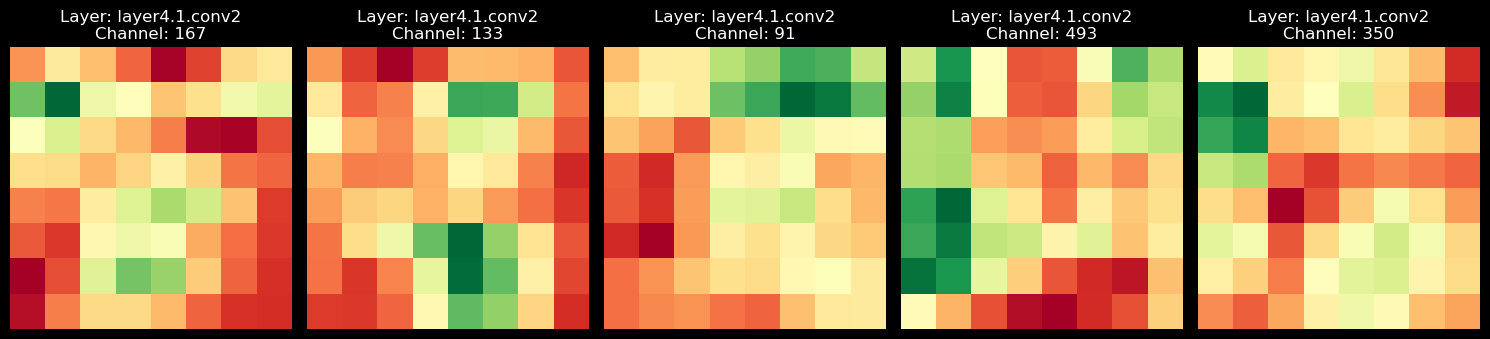

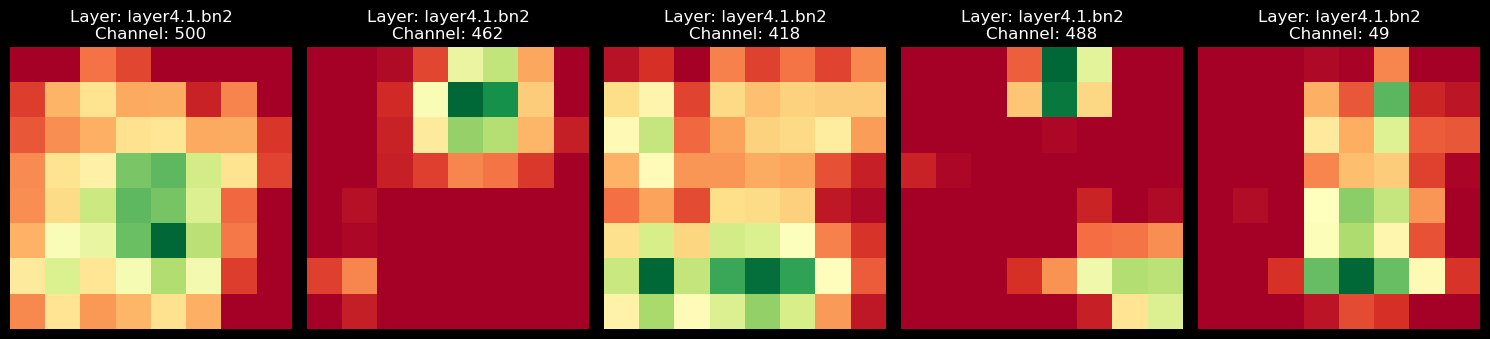

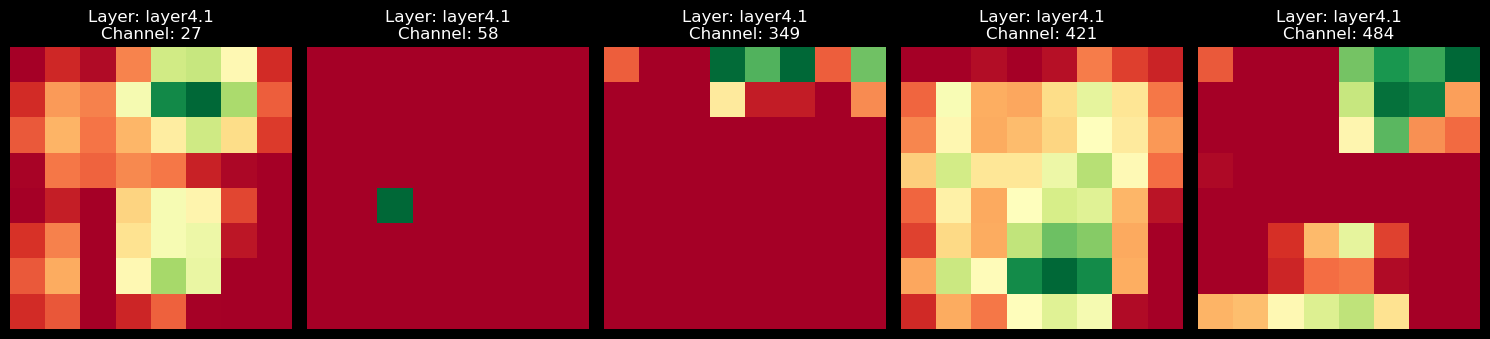

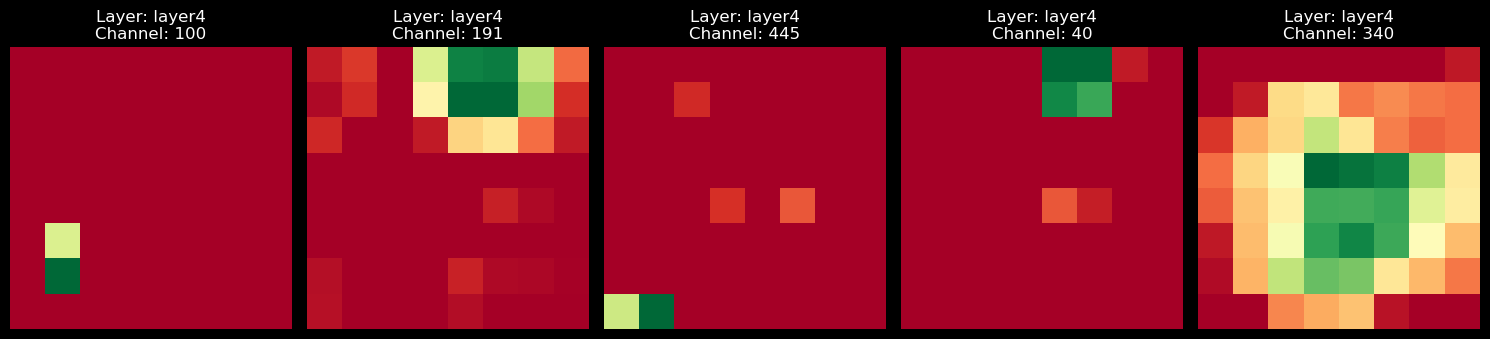

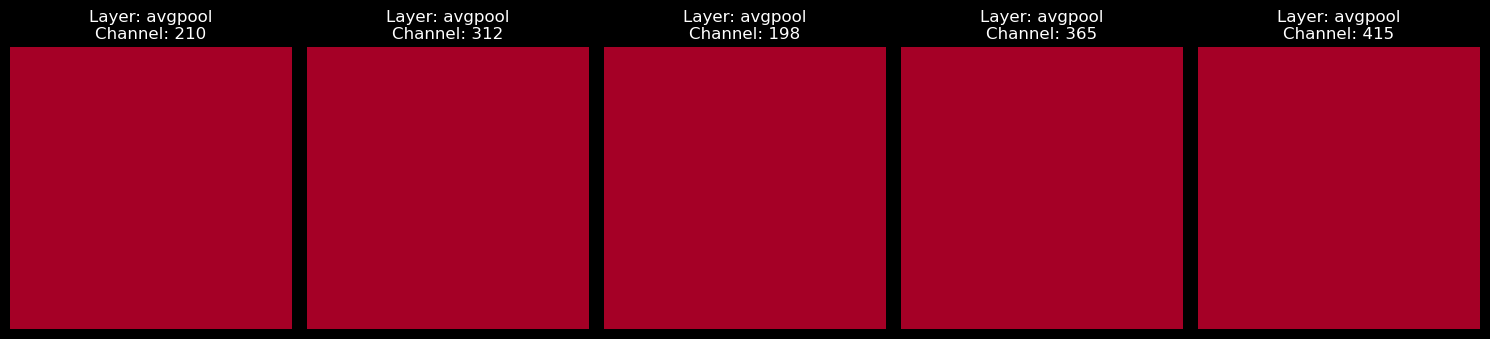

In [10]:
import matplotlib.pyplot as plt

# Function to plot activations
def plot_activations(activations, num_activations=5):
    for layer_name, activation in activations.items():
        # Check if activation is a 4D tensor (batch_size, channels, height, width)
        if activation.dim() == 4:
            # Get the number of channels
            num_channels = activation.size(1)
            # Randomly select channels to plot
            channel_indices = random.sample(range(num_channels), min(num_activations, num_channels))
            
            fig, axes = plt.subplots(1, len(channel_indices), figsize=(15, 5))
            for idx, channel_idx in enumerate(channel_indices):
                ax = axes[idx]
                # Extract the activation of the selected channel
                act = activation[0, channel_idx].cpu().numpy()
                ax.imshow(act, cmap='RdYlGn')
                ax.axis('off')
                ax.set_title(f'Layer: {layer_name}\nChannel: {channel_idx}')
            plt.tight_layout()
            plt.show()

# Plot activations
plot_activations(activations, num_activations=5)